In [2]:
import numpy as np
import optuna
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from optuna import Trial, Study
from braindecode.models import EEGNetv4, HybridNet, EEGResNet, TCN, EEGInceptionMI
from braindecode.augmentation import AugmentedDataLoader
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from utils.training import train, best_torch_device
from torchinfo import summary
from copy import copy, deepcopy
from prepare_data import get_frequency_dataloader, get_raw_dataloader, get_sub1_dataloader, get_time_series_dataloader

%load_ext autoreload
%autoreload 2

In [3]:
bsz = 32

train_loader, val_loader, test_loader = get_raw_dataloader(batch_size=bsz)
train_aug_loader, _, _ = get_frequency_dataloader(batch_size=bsz)
train_sub_loader, val_sub_loader, test_sub_loader = get_sub1_dataloader(batch_size=bsz)


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.filter_nums1 = 24 # 8
        self.filter_nums2 = 120 # 40
        self.filter_nums3 = 32 # 12
        num_groups = 8
        b = True
        dropout_prob = 0.25

        self.conv_over_time = nn.Sequential(
            nn.Conv2d(1, self.filter_nums1, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=b),
            nn.BatchNorm2d(self.filter_nums1, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
        # (n, 8, 22, 1001)

        self.conv_over_channels = nn.Sequential(
            nn.Conv2d(self.filter_nums1, self.filter_nums2, kernel_size=(22, 1), stride=(1, 1), groups=num_groups, bias=b),
            nn.BatchNorm2d(self.filter_nums2, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0), # pool over time to shrink time
            nn.Dropout(p=dropout_prob)
        )
        # (n, 40, 1, 250)

        self.conv_by_channel_and_point = nn.Sequential(
            nn.Conv2d(self.filter_nums2, self.filter_nums2, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=num_groups, bias=b),
            # (n, 40, 1, 251)
            nn.Conv2d(self.filter_nums2, self.filter_nums3, kernel_size=(1, 1), stride=(1, 1), bias=False),
            # (n, 12, 1, 251)
            nn.BatchNorm2d(self.filter_nums3, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=dropout_prob),
            # (n, 12, 1, 31)
            nn.Conv2d(self.filter_nums3, 4, kernel_size=(1, 31), stride=(1, 1)) # conv to 4 output classes
            # (n, 4, 1, 1)
        )
        

    def forward(self, x):
        # x = x.to('mps')
        # X (batch, ch, t)
        x = x.unsqueeze(3)
        # (batch, ch, t, 1)
        x = x.permute(0, 3, 1, 2)
        # (batch, 1, ch, t)
        x = self.conv_over_time(x)
        x = self.conv_over_channels(x)
        x = self.conv_by_channel_and_point(x)
        x = x.squeeze(-1)
        x = x.squeeze(-1)
        return x

In [5]:
device = torch.device('mps')

model = CNN()
model = model.to(device)
print(model)
summary(model, input_size=(2, 22, 1000), device='mps')

CNN(
  (conv_over_time): Sequential(
    (0): Conv2d(1, 24, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (conv_over_channels): Sequential(
    (0): Conv2d(24, 120, kernel_size=(22, 1), stride=(1, 1), groups=8)
    (1): BatchNorm2d(120, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv_by_channel_and_point): Sequential(
    (0): Conv2d(120, 120, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=8)
    (1): Conv2d(120, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 4, kernel_size=(1, 3

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [2, 4]                    --
├─Sequential: 1-1                        [2, 24, 22, 1001]         --
│    └─Conv2d: 2-1                       [2, 24, 22, 1001]         1,560
│    └─BatchNorm2d: 2-2                  [2, 24, 22, 1001]         48
├─Sequential: 1-2                        [2, 120, 1, 250]          --
│    └─Conv2d: 2-3                       [2, 120, 1, 1001]         8,040
│    └─BatchNorm2d: 2-4                  [2, 120, 1, 1001]         240
│    └─ELU: 2-5                          [2, 120, 1, 1001]         --
│    └─AvgPool2d: 2-6                    [2, 120, 1, 250]          --
│    └─Dropout: 2-7                      [2, 120, 1, 250]          --
├─Sequential: 1-3                        [2, 4, 1, 1]              --
│    └─Conv2d: 2-8                       [2, 120, 1, 251]          28,920
│    └─Conv2d: 2-9                       [2, 32, 1, 251]           3,840
│

## Train with raw data

In [70]:
from utils.training import train

raw_model = model
raw_model.to(device)

optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

tr_loader = train_loader

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    loss_func=nn.CrossEntropyLoss(),
    train_data=tr_loader,
    val_data=val_loader,
    early_stopping_patience=10,
    scheduler=scheduler,
    cp_path="models/cnn",
    cp_filename="raw.pt",
    n_epochs=150,
    show_progress_bar=True,
)

Using device: mps


Epoch 0: 100%|██████████| 28/28 [00:09<00:00,  2.84batch/s, loss=1.3824]


[Epoch 0] val_acc=0.357988 train_acc=0.353405 val_loss=0.023736 train_loss=0.021379
Validation loss decreased (inf --> 0.023736).  Saving model ...


Epoch 1: 100%|██████████| 28/28 [00:07<00:00,  3.71batch/s, loss=1.1662]


[Epoch 1] val_acc=0.443787 train_acc=0.459201 val_loss=0.022913 train_loss=0.019640
Validation loss decreased (0.023736 --> 0.022913).  Saving model ...


Epoch 2: 100%|██████████| 28/28 [00:07<00:00,  3.58batch/s, loss=1.2602]


[Epoch 2] val_acc=0.434911 train_acc=0.551491 val_loss=0.021676 train_loss=0.018209
Validation loss decreased (0.022913 --> 0.021676).  Saving model ...


Epoch 3: 100%|██████████| 28/28 [00:07<00:00,  3.67batch/s, loss=1.0452]


[Epoch 3] val_acc=0.505917 train_acc=0.597636 val_loss=0.020794 train_loss=0.017345
Validation loss decreased (0.021676 --> 0.020794).  Saving model ...


Epoch 4: 100%|██████████| 28/28 [00:07<00:00,  3.66batch/s, loss=1.0705]


[Epoch 4] val_acc=0.544379 train_acc=0.625774 val_loss=0.020160 train_loss=0.016579
Validation loss decreased (0.020794 --> 0.020160).  Saving model ...


Epoch 5: 100%|██████████| 28/28 [00:07<00:00,  3.64batch/s, loss=0.9699]


[Epoch 5] val_acc=0.565089 train_acc=0.661227 val_loss=0.019387 train_loss=0.015974
Validation loss decreased (0.020160 --> 0.019387).  Saving model ...


Epoch 6: 100%|██████████| 28/28 [00:07<00:00,  3.70batch/s, loss=1.0447]


[Epoch 6] val_acc=0.550296 train_acc=0.672482 val_loss=0.019383 train_loss=0.015597
Validation loss decreased (0.019387 --> 0.019383).  Saving model ...


Epoch 7: 100%|██████████| 28/28 [00:07<00:00,  3.71batch/s, loss=1.0124]


[Epoch 7] val_acc=0.568047 train_acc=0.676984 val_loss=0.018573 train_loss=0.015461
Validation loss decreased (0.019383 --> 0.018573).  Saving model ...


Epoch 8: 100%|██████████| 28/28 [00:07<00:00,  3.64batch/s, loss=0.9403]


[Epoch 8] val_acc=0.573964 train_acc=0.716939 val_loss=0.018322 train_loss=0.014788
Validation loss decreased (0.018573 --> 0.018322).  Saving model ...


Epoch 9: 100%|██████████| 28/28 [00:08<00:00,  3.42batch/s, loss=0.9424]


[Epoch 9] val_acc=0.568047 train_acc=0.718627 val_loss=0.017688 train_loss=0.014722
Validation loss decreased (0.018322 --> 0.017688).  Saving model ...


Epoch 10: 100%|██████████| 28/28 [00:08<00:00,  3.45batch/s, loss=0.8313]


[Epoch 10] val_acc=0.615385 train_acc=0.732696 val_loss=0.016444 train_loss=0.014354
Validation loss decreased (0.017688 --> 0.016444).  Saving model ...


Epoch 11: 100%|██████████| 28/28 [00:08<00:00,  3.48batch/s, loss=0.9121]


[Epoch 11] val_acc=0.639053 train_acc=0.740574 val_loss=0.015971 train_loss=0.013913
Validation loss decreased (0.016444 --> 0.015971).  Saving model ...


Epoch 12: 100%|██████████| 28/28 [00:08<00:00,  3.35batch/s, loss=0.8729]


[Epoch 12] val_acc=0.630178 train_acc=0.764209 val_loss=0.016293 train_loss=0.013750
EarlyStopping counter: 1 out of 30


Epoch 13: 100%|██████████| 28/28 [00:08<00:00,  3.49batch/s, loss=1.0707]


[Epoch 13] val_acc=0.621302 train_acc=0.756331 val_loss=0.016292 train_loss=0.013756
EarlyStopping counter: 2 out of 30


Epoch 14: 100%|██████████| 28/28 [00:08<00:00,  3.38batch/s, loss=0.7368]


[Epoch 14] val_acc=0.650888 train_acc=0.770400 val_loss=0.015350 train_loss=0.013419
Validation loss decreased (0.015971 --> 0.015350).  Saving model ...


Epoch 15: 100%|██████████| 28/28 [00:08<00:00,  3.32batch/s, loss=0.8673]


[Epoch 15] val_acc=0.680473 train_acc=0.773213 val_loss=0.014377 train_loss=0.013399
Validation loss decreased (0.015350 --> 0.014377).  Saving model ...


Epoch 16: 100%|██████████| 28/28 [00:08<00:00,  3.38batch/s, loss=0.7201]


[Epoch 16] val_acc=0.656805 train_acc=0.790096 val_loss=0.015229 train_loss=0.012981
EarlyStopping counter: 1 out of 30


Epoch 17: 100%|██████████| 28/28 [00:08<00:00,  3.43batch/s, loss=0.7063]


[Epoch 17] val_acc=0.707101 train_acc=0.802476 val_loss=0.013987 train_loss=0.012956
Validation loss decreased (0.014377 --> 0.013987).  Saving model ...


Epoch 18: 100%|██████████| 28/28 [00:07<00:00,  3.73batch/s, loss=0.7665]


[Epoch 18] val_acc=0.680473 train_acc=0.808666 val_loss=0.014275 train_loss=0.012643
EarlyStopping counter: 1 out of 30


Epoch 19: 100%|██████████| 28/28 [00:08<00:00,  3.46batch/s, loss=0.8496]


[Epoch 19] val_acc=0.695266 train_acc=0.815982 val_loss=0.014335 train_loss=0.012564
EarlyStopping counter: 2 out of 30


Epoch 20: 100%|██████████| 28/28 [00:08<00:00,  3.45batch/s, loss=0.8162]


[Epoch 20] val_acc=0.707101 train_acc=0.813731 val_loss=0.013410 train_loss=0.012491
Validation loss decreased (0.013987 --> 0.013410).  Saving model ...


Epoch 21: 100%|██████████| 28/28 [00:08<00:00,  3.42batch/s, loss=0.7426]


[Epoch 21] val_acc=0.698225 train_acc=0.823860 val_loss=0.013821 train_loss=0.012318
EarlyStopping counter: 1 out of 30


Epoch 22: 100%|██████████| 28/28 [00:07<00:00,  3.51batch/s, loss=0.7893]


[Epoch 22] val_acc=0.718935 train_acc=0.828362 val_loss=0.013437 train_loss=0.012255
EarlyStopping counter: 2 out of 30


Epoch 23: 100%|██████████| 28/28 [00:08<00:00,  3.49batch/s, loss=0.7095]


[Epoch 23] val_acc=0.698225 train_acc=0.832864 val_loss=0.014214 train_loss=0.012152
EarlyStopping counter: 3 out of 30


Epoch 24: 100%|██████████| 28/28 [00:07<00:00,  3.60batch/s, loss=0.7462]


[Epoch 24] val_acc=0.689349 train_acc=0.833990 val_loss=0.014267 train_loss=0.012001
EarlyStopping counter: 4 out of 30


Epoch 25: 100%|██████████| 28/28 [00:07<00:00,  3.52batch/s, loss=0.7261]


[Epoch 25] val_acc=0.689349 train_acc=0.832864 val_loss=0.013676 train_loss=0.011950
EarlyStopping counter: 5 out of 30


Epoch 26: 100%|██████████| 28/28 [00:07<00:00,  3.64batch/s, loss=0.9240]


[Epoch 26] val_acc=0.671598 train_acc=0.841306 val_loss=0.014374 train_loss=0.011957
EarlyStopping counter: 6 out of 30


Epoch 27: 100%|██████████| 28/28 [00:07<00:00,  3.53batch/s, loss=0.6978]


[Epoch 27] val_acc=0.671598 train_acc=0.853123 val_loss=0.013923 train_loss=0.011676
EarlyStopping counter: 7 out of 30


Epoch 28: 100%|██████████| 28/28 [00:07<00:00,  3.57batch/s, loss=0.8211]


[Epoch 28] val_acc=0.715976 train_acc=0.859876 val_loss=0.013378 train_loss=0.011660
Validation loss decreased (0.013410 --> 0.013378).  Saving model ...


Epoch 29: 100%|██████████| 28/28 [00:08<00:00,  3.40batch/s, loss=0.8633]


[Epoch 29] val_acc=0.724852 train_acc=0.851435 val_loss=0.013158 train_loss=0.011779
Validation loss decreased (0.013378 --> 0.013158).  Saving model ...


Epoch 30: 100%|██████████| 28/28 [00:07<00:00,  3.73batch/s, loss=0.7769]


[Epoch 30] val_acc=0.692308 train_acc=0.853123 val_loss=0.013564 train_loss=0.011537
EarlyStopping counter: 1 out of 30


Epoch 31: 100%|██████████| 28/28 [00:07<00:00,  3.51batch/s, loss=0.6805]


[Epoch 31] val_acc=0.704142 train_acc=0.858751 val_loss=0.013557 train_loss=0.011488
EarlyStopping counter: 2 out of 30


Epoch 32: 100%|██████████| 28/28 [00:08<00:00,  3.38batch/s, loss=0.7070]


[Epoch 32] val_acc=0.683432 train_acc=0.858188 val_loss=0.013527 train_loss=0.011546
EarlyStopping counter: 3 out of 30


Epoch 33: 100%|██████████| 28/28 [00:08<00:00,  3.34batch/s, loss=0.7304]


[Epoch 33] val_acc=0.701183 train_acc=0.869443 val_loss=0.013189 train_loss=0.011430
EarlyStopping counter: 4 out of 30


Epoch 34: 100%|██████████| 28/28 [00:08<00:00,  3.33batch/s, loss=0.8200]


[Epoch 34] val_acc=0.689349 train_acc=0.873945 val_loss=0.013262 train_loss=0.011269
EarlyStopping counter: 5 out of 30


Epoch 35: 100%|██████████| 28/28 [00:08<00:00,  3.35batch/s, loss=0.7652]


[Epoch 35] val_acc=0.704142 train_acc=0.870006 val_loss=0.013103 train_loss=0.011414
Validation loss decreased (0.013158 --> 0.013103).  Saving model ...


Epoch 36: 100%|██████████| 28/28 [00:07<00:00,  3.55batch/s, loss=0.7243]


[Epoch 36] val_acc=0.718935 train_acc=0.882386 val_loss=0.013017 train_loss=0.011071
Validation loss decreased (0.013103 --> 0.013017).  Saving model ...


Epoch 37: 100%|██████████| 28/28 [00:08<00:00,  3.48batch/s, loss=0.7928]


[Epoch 37] val_acc=0.730769 train_acc=0.877321 val_loss=0.012945 train_loss=0.011126
Validation loss decreased (0.013017 --> 0.012945).  Saving model ...


Epoch 38: 100%|██████████| 28/28 [00:08<00:00,  3.35batch/s, loss=0.7915]


[Epoch 38] val_acc=0.698225 train_acc=0.872819 val_loss=0.013419 train_loss=0.011234
EarlyStopping counter: 1 out of 30


Epoch 39: 100%|██████████| 28/28 [00:07<00:00,  3.55batch/s, loss=0.7916]


[Epoch 39] val_acc=0.683432 train_acc=0.871131 val_loss=0.013756 train_loss=0.011160
EarlyStopping counter: 2 out of 30


Epoch 40: 100%|██████████| 28/28 [00:07<00:00,  3.58batch/s, loss=0.6915]


[Epoch 40] val_acc=0.698225 train_acc=0.879010 val_loss=0.013827 train_loss=0.011064
EarlyStopping counter: 3 out of 30


Epoch 41: 100%|██████████| 28/28 [00:07<00:00,  3.56batch/s, loss=0.6851]


[Epoch 41] val_acc=0.715976 train_acc=0.889702 val_loss=0.012930 train_loss=0.010964
Validation loss decreased (0.012945 --> 0.012930).  Saving model ...


Epoch 42: 100%|██████████| 28/28 [00:07<00:00,  3.57batch/s, loss=0.7252]


[Epoch 42] val_acc=0.715976 train_acc=0.882386 val_loss=0.013183 train_loss=0.010999
EarlyStopping counter: 1 out of 30


Epoch 43: 100%|██████████| 28/28 [00:07<00:00,  3.58batch/s, loss=0.6928]


[Epoch 43] val_acc=0.692308 train_acc=0.889139 val_loss=0.012964 train_loss=0.010779
EarlyStopping counter: 2 out of 30


Epoch 44: 100%|██████████| 28/28 [00:08<00:00,  3.42batch/s, loss=0.6752]


[Epoch 44] val_acc=0.713018 train_acc=0.891390 val_loss=0.013204 train_loss=0.010925
EarlyStopping counter: 3 out of 30


Epoch 45: 100%|██████████| 28/28 [00:08<00:00,  3.25batch/s, loss=0.6583]


[Epoch 45] val_acc=0.724852 train_acc=0.892515 val_loss=0.012722 train_loss=0.010754
Validation loss decreased (0.012930 --> 0.012722).  Saving model ...


Epoch 46: 100%|██████████| 28/28 [00:08<00:00,  3.32batch/s, loss=0.6588]


[Epoch 46] val_acc=0.704142 train_acc=0.900394 val_loss=0.013077 train_loss=0.010632
EarlyStopping counter: 1 out of 30


Epoch 47: 100%|██████████| 28/28 [00:08<00:00,  3.25batch/s, loss=0.6617]


[Epoch 47] val_acc=0.707101 train_acc=0.893641 val_loss=0.013109 train_loss=0.010755
EarlyStopping counter: 2 out of 30


Epoch 48: 100%|██████████| 28/28 [00:08<00:00,  3.37batch/s, loss=0.6801]


[Epoch 48] val_acc=0.686391 train_acc=0.909398 val_loss=0.013510 train_loss=0.010529
EarlyStopping counter: 3 out of 30


Epoch 49: 100%|██████████| 28/28 [00:08<00:00,  3.42batch/s, loss=0.7154]


[Epoch 49] val_acc=0.698225 train_acc=0.903208 val_loss=0.013134 train_loss=0.010586
EarlyStopping counter: 4 out of 30


Epoch 50: 100%|██████████| 28/28 [00:08<00:00,  3.27batch/s, loss=0.6738]


[Epoch 50] val_acc=0.707101 train_acc=0.910523 val_loss=0.012807 train_loss=0.010533
EarlyStopping counter: 5 out of 30


Epoch 51: 100%|██████████| 28/28 [00:08<00:00,  3.13batch/s, loss=0.6417]


[Epoch 51] val_acc=0.724852 train_acc=0.906584 val_loss=0.012981 train_loss=0.010547
EarlyStopping counter: 6 out of 30


Epoch 52: 100%|██████████| 28/28 [00:08<00:00,  3.27batch/s, loss=0.6216]


[Epoch 52] val_acc=0.715976 train_acc=0.891390 val_loss=0.012448 train_loss=0.010824
Validation loss decreased (0.012722 --> 0.012448).  Saving model ...


Epoch 53: 100%|██████████| 28/28 [00:08<00:00,  3.16batch/s, loss=0.6715]


[Epoch 53] val_acc=0.680473 train_acc=0.917276 val_loss=0.013793 train_loss=0.010492
EarlyStopping counter: 1 out of 30


Epoch 54: 100%|██████████| 28/28 [00:09<00:00,  3.07batch/s, loss=0.6350]


[Epoch 54] val_acc=0.713018 train_acc=0.909961 val_loss=0.013172 train_loss=0.010427
EarlyStopping counter: 2 out of 30


Epoch 55: 100%|██████████| 28/28 [00:09<00:00,  2.95batch/s, loss=0.7180]


[Epoch 55] val_acc=0.713018 train_acc=0.913337 val_loss=0.013183 train_loss=0.010414
EarlyStopping counter: 3 out of 30


Epoch 56: 100%|██████████| 28/28 [00:11<00:00,  2.46batch/s, loss=0.6755]


[Epoch 56] val_acc=0.742604 train_acc=0.913337 val_loss=0.013214 train_loss=0.010476
EarlyStopping counter: 4 out of 30


Epoch 57: 100%|██████████| 28/28 [00:13<00:00,  2.12batch/s, loss=0.6473]


[Epoch 57] val_acc=0.692308 train_acc=0.899268 val_loss=0.013186 train_loss=0.010573
EarlyStopping counter: 5 out of 30


Epoch 58: 100%|██████████| 28/28 [00:11<00:00,  2.46batch/s, loss=0.7765]


[Epoch 58] val_acc=0.689349 train_acc=0.907710 val_loss=0.012988 train_loss=0.010481
EarlyStopping counter: 6 out of 30


Epoch 59: 100%|██████████| 28/28 [00:12<00:00,  2.25batch/s, loss=0.7132]


[Epoch 59] val_acc=0.701183 train_acc=0.900957 val_loss=0.012635 train_loss=0.010446
EarlyStopping counter: 7 out of 30


Epoch 60: 100%|██████████| 28/28 [00:10<00:00,  2.62batch/s, loss=0.6524]


[Epoch 60] val_acc=0.695266 train_acc=0.920653 val_loss=0.012452 train_loss=0.010304
EarlyStopping counter: 8 out of 30


Epoch 61: 100%|██████████| 28/28 [00:10<00:00,  2.64batch/s, loss=0.6966]


[Epoch 61] val_acc=0.710059 train_acc=0.913337 val_loss=0.013085 train_loss=0.010414
EarlyStopping counter: 9 out of 30


Epoch 62: 100%|██████████| 28/28 [00:11<00:00,  2.39batch/s, loss=0.7116]


[Epoch 62] val_acc=0.695266 train_acc=0.913900 val_loss=0.013038 train_loss=0.010316
EarlyStopping counter: 10 out of 30


Epoch 63: 100%|██████████| 28/28 [00:11<00:00,  2.50batch/s, loss=0.5942]


[Epoch 63] val_acc=0.710059 train_acc=0.921778 val_loss=0.012664 train_loss=0.010194
EarlyStopping counter: 11 out of 30


Epoch 64: 100%|██████████| 28/28 [00:11<00:00,  2.37batch/s, loss=0.6421]


[Epoch 64] val_acc=0.721893 train_acc=0.926843 val_loss=0.012839 train_loss=0.010182
EarlyStopping counter: 12 out of 30


Epoch 65: 100%|██████████| 28/28 [00:11<00:00,  2.41batch/s, loss=0.6743]


[Epoch 65] val_acc=0.718935 train_acc=0.924592 val_loss=0.012677 train_loss=0.010161
EarlyStopping counter: 13 out of 30


Epoch 66: 100%|██████████| 28/28 [00:10<00:00,  2.74batch/s, loss=0.6732]


[Epoch 66] val_acc=0.715976 train_acc=0.918965 val_loss=0.012462 train_loss=0.010218
EarlyStopping counter: 14 out of 30


Epoch 67: 100%|██████████| 28/28 [00:09<00:00,  2.96batch/s, loss=0.6665]


[Epoch 67] val_acc=0.715976 train_acc=0.919527 val_loss=0.012787 train_loss=0.010255
EarlyStopping counter: 15 out of 30


Epoch 68: 100%|██████████| 28/28 [00:09<00:00,  2.92batch/s, loss=0.6470]


[Epoch 68] val_acc=0.704142 train_acc=0.920090 val_loss=0.013260 train_loss=0.010178
EarlyStopping counter: 16 out of 30


Epoch 69: 100%|██████████| 28/28 [00:10<00:00,  2.67batch/s, loss=0.6178]


[Epoch 69] val_acc=0.713018 train_acc=0.920653 val_loss=0.013157 train_loss=0.010237
EarlyStopping counter: 17 out of 30


Epoch 70: 100%|██████████| 28/28 [00:08<00:00,  3.13batch/s, loss=0.6844]


[Epoch 70] val_acc=0.710059 train_acc=0.920653 val_loss=0.013036 train_loss=0.010163
EarlyStopping counter: 18 out of 30


Epoch 71: 100%|██████████| 28/28 [00:08<00:00,  3.16batch/s, loss=0.7044]


[Epoch 71] val_acc=0.707101 train_acc=0.928531 val_loss=0.013127 train_loss=0.010137
EarlyStopping counter: 19 out of 30


Epoch 72: 100%|██████████| 28/28 [00:08<00:00,  3.31batch/s, loss=0.6244]


[Epoch 72] val_acc=0.698225 train_acc=0.936410 val_loss=0.013219 train_loss=0.010030
EarlyStopping counter: 20 out of 30


Epoch 73: 100%|██████████| 28/28 [00:09<00:00,  2.87batch/s, loss=0.7031]


[Epoch 73] val_acc=0.713018 train_acc=0.925155 val_loss=0.012814 train_loss=0.010070
EarlyStopping counter: 21 out of 30


Epoch 74: 100%|██████████| 28/28 [00:10<00:00,  2.74batch/s, loss=0.6117]


[Epoch 74] val_acc=0.736686 train_acc=0.933033 val_loss=0.012408 train_loss=0.009929
Validation loss decreased (0.012448 --> 0.012408).  Saving model ...


Epoch 75: 100%|██████████| 28/28 [00:10<00:00,  2.63batch/s, loss=0.6387]


[Epoch 75] val_acc=0.701183 train_acc=0.938661 val_loss=0.012986 train_loss=0.009933
EarlyStopping counter: 1 out of 30


Epoch 76: 100%|██████████| 28/28 [00:08<00:00,  3.20batch/s, loss=0.6503]


[Epoch 76] val_acc=0.724852 train_acc=0.926280 val_loss=0.012720 train_loss=0.010058
EarlyStopping counter: 2 out of 30


Epoch 77: 100%|██████████| 28/28 [00:09<00:00,  2.86batch/s, loss=0.6352]


[Epoch 77] val_acc=0.695266 train_acc=0.928531 val_loss=0.012692 train_loss=0.009921
EarlyStopping counter: 3 out of 30


Epoch 78: 100%|██████████| 28/28 [00:10<00:00,  2.78batch/s, loss=0.5831]


[Epoch 78] val_acc=0.701183 train_acc=0.933033 val_loss=0.013387 train_loss=0.010118
EarlyStopping counter: 4 out of 30


Epoch 79: 100%|██████████| 28/28 [00:09<00:00,  2.98batch/s, loss=0.6811]


[Epoch 79] val_acc=0.701183 train_acc=0.931908 val_loss=0.013444 train_loss=0.010023
EarlyStopping counter: 5 out of 30


Epoch 80: 100%|██████████| 28/28 [00:09<00:00,  3.05batch/s, loss=0.6541]


[Epoch 80] val_acc=0.692308 train_acc=0.934159 val_loss=0.013381 train_loss=0.010041
EarlyStopping counter: 6 out of 30


Epoch 81: 100%|██████████| 28/28 [00:08<00:00,  3.19batch/s, loss=0.6434]


[Epoch 81] val_acc=0.695266 train_acc=0.933033 val_loss=0.012793 train_loss=0.010073
EarlyStopping counter: 7 out of 30


Epoch 82: 100%|██████████| 28/28 [00:08<00:00,  3.17batch/s, loss=0.6042]


[Epoch 82] val_acc=0.704142 train_acc=0.920653 val_loss=0.012888 train_loss=0.010104
EarlyStopping counter: 8 out of 30


Epoch 83: 100%|██████████| 28/28 [00:08<00:00,  3.48batch/s, loss=0.6701]


[Epoch 83] val_acc=0.715976 train_acc=0.943725 val_loss=0.012754 train_loss=0.009804
EarlyStopping counter: 9 out of 30


Epoch 84: 100%|██████████| 28/28 [00:08<00:00,  3.21batch/s, loss=0.6302]


[Epoch 84] val_acc=0.715976 train_acc=0.940912 val_loss=0.013059 train_loss=0.009862
EarlyStopping counter: 10 out of 30


Epoch 85: 100%|██████████| 28/28 [00:08<00:00,  3.30batch/s, loss=0.6116]


[Epoch 85] val_acc=0.707101 train_acc=0.935847 val_loss=0.012762 train_loss=0.009925
EarlyStopping counter: 11 out of 30


Epoch 86: 100%|██████████| 28/28 [00:09<00:00,  2.98batch/s, loss=0.6276]


[Epoch 86] val_acc=0.692308 train_acc=0.939786 val_loss=0.013372 train_loss=0.009757
EarlyStopping counter: 12 out of 30


Epoch 87: 100%|██████████| 28/28 [00:08<00:00,  3.17batch/s, loss=0.6512]


[Epoch 87] val_acc=0.692308 train_acc=0.938661 val_loss=0.012984 train_loss=0.009738
EarlyStopping counter: 13 out of 30


Epoch 88: 100%|██████████| 28/28 [00:08<00:00,  3.43batch/s, loss=0.6045]


[Epoch 88] val_acc=0.713018 train_acc=0.936972 val_loss=0.013197 train_loss=0.009830
EarlyStopping counter: 14 out of 30


Epoch 89: 100%|██████████| 28/28 [00:08<00:00,  3.40batch/s, loss=0.6511]


[Epoch 89] val_acc=0.704142 train_acc=0.943163 val_loss=0.013207 train_loss=0.009788
EarlyStopping counter: 15 out of 30


Epoch 90: 100%|██████████| 28/28 [00:08<00:00,  3.14batch/s, loss=0.6432]


[Epoch 90] val_acc=0.701183 train_acc=0.942037 val_loss=0.013320 train_loss=0.009839
EarlyStopping counter: 16 out of 30


Epoch 91: 100%|██████████| 28/28 [00:08<00:00,  3.38batch/s, loss=0.6242]


[Epoch 91] val_acc=0.710059 train_acc=0.933596 val_loss=0.012923 train_loss=0.009745
EarlyStopping counter: 17 out of 30


Epoch 92: 100%|██████████| 28/28 [00:08<00:00,  3.34batch/s, loss=0.6782]


[Epoch 92] val_acc=0.727811 train_acc=0.942037 val_loss=0.012888 train_loss=0.009860
EarlyStopping counter: 18 out of 30


Epoch 93: 100%|██████████| 28/28 [00:08<00:00,  3.23batch/s, loss=0.6255]


[Epoch 93] val_acc=0.718935 train_acc=0.949353 val_loss=0.012794 train_loss=0.009650
EarlyStopping counter: 19 out of 30


Epoch 94: 100%|██████████| 28/28 [00:10<00:00,  2.75batch/s, loss=0.6840]


[Epoch 94] val_acc=0.730769 train_acc=0.944851 val_loss=0.013210 train_loss=0.009760
EarlyStopping counter: 20 out of 30


Epoch 95: 100%|██████████| 28/28 [00:09<00:00,  2.95batch/s, loss=0.5924]


[Epoch 95] val_acc=0.733728 train_acc=0.938098 val_loss=0.012835 train_loss=0.009771
EarlyStopping counter: 21 out of 30


Epoch 96: 100%|██████████| 28/28 [00:08<00:00,  3.33batch/s, loss=0.6399]


[Epoch 96] val_acc=0.730769 train_acc=0.948227 val_loss=0.012703 train_loss=0.009595
EarlyStopping counter: 22 out of 30


Epoch 97: 100%|██████████| 28/28 [00:08<00:00,  3.47batch/s, loss=0.5955]


[Epoch 97] val_acc=0.721893 train_acc=0.947102 val_loss=0.012409 train_loss=0.009614
EarlyStopping counter: 23 out of 30


Epoch 98: 100%|██████████| 28/28 [00:09<00:00,  2.90batch/s, loss=0.5913]


[Epoch 98] val_acc=0.710059 train_acc=0.951604 val_loss=0.013081 train_loss=0.009608
EarlyStopping counter: 24 out of 30


Epoch 99: 100%|██████████| 28/28 [00:09<00:00,  2.99batch/s, loss=0.6222]


[Epoch 99] val_acc=0.718935 train_acc=0.942600 val_loss=0.012344 train_loss=0.009715
Validation loss decreased (0.012408 --> 0.012344).  Saving model ...


Epoch 100: 100%|██████████| 28/28 [00:08<00:00,  3.12batch/s, loss=0.6167]


[Epoch 100] val_acc=0.707101 train_acc=0.948227 val_loss=0.012740 train_loss=0.009588
EarlyStopping counter: 1 out of 30


Epoch 101: 100%|██████████| 28/28 [00:08<00:00,  3.21batch/s, loss=0.6197]


[Epoch 101] val_acc=0.713018 train_acc=0.952167 val_loss=0.012931 train_loss=0.009548
EarlyStopping counter: 2 out of 30


Epoch 102: 100%|██████████| 28/28 [00:09<00:00,  3.05batch/s, loss=0.6695]


[Epoch 102] val_acc=0.710059 train_acc=0.943725 val_loss=0.012926 train_loss=0.009639
EarlyStopping counter: 3 out of 30


Epoch 103: 100%|██████████| 28/28 [00:08<00:00,  3.46batch/s, loss=0.6057]


[Epoch 103] val_acc=0.701183 train_acc=0.942037 val_loss=0.012893 train_loss=0.009671
EarlyStopping counter: 4 out of 30


Epoch 104: 100%|██████████| 28/28 [00:08<00:00,  3.42batch/s, loss=0.5528]


[Epoch 104] val_acc=0.724852 train_acc=0.957231 val_loss=0.012415 train_loss=0.009364
EarlyStopping counter: 5 out of 30


Epoch 105: 100%|██████████| 28/28 [00:11<00:00,  2.49batch/s, loss=0.6174]


[Epoch 105] val_acc=0.701183 train_acc=0.951041 val_loss=0.012665 train_loss=0.009477
EarlyStopping counter: 6 out of 30


Epoch 106: 100%|██████████| 28/28 [00:09<00:00,  2.99batch/s, loss=0.6340]


[Epoch 106] val_acc=0.715976 train_acc=0.949353 val_loss=0.012833 train_loss=0.009527
EarlyStopping counter: 7 out of 30


Epoch 107: 100%|██████████| 28/28 [00:08<00:00,  3.15batch/s, loss=0.5928]


[Epoch 107] val_acc=0.704142 train_acc=0.940912 val_loss=0.013019 train_loss=0.009797
EarlyStopping counter: 8 out of 30


Epoch 108: 100%|██████████| 28/28 [00:10<00:00,  2.65batch/s, loss=0.5940]


[Epoch 108] val_acc=0.686391 train_acc=0.952167 val_loss=0.013315 train_loss=0.009476
EarlyStopping counter: 9 out of 30


Epoch 109: 100%|██████████| 28/28 [00:09<00:00,  3.06batch/s, loss=0.6416]


[Epoch 109] val_acc=0.713018 train_acc=0.944288 val_loss=0.012829 train_loss=0.009625
EarlyStopping counter: 10 out of 30


Epoch 110: 100%|██████████| 28/28 [00:09<00:00,  2.81batch/s, loss=0.6111]


[Epoch 110] val_acc=0.736686 train_acc=0.955543 val_loss=0.012487 train_loss=0.009433
EarlyStopping counter: 11 out of 30


Epoch 111: 100%|██████████| 28/28 [00:11<00:00,  2.54batch/s, loss=0.6109]


[Epoch 111] val_acc=0.724852 train_acc=0.960608 val_loss=0.012783 train_loss=0.009274
EarlyStopping counter: 12 out of 30


Epoch 112: 100%|██████████| 28/28 [00:10<00:00,  2.59batch/s, loss=0.6037]


[Epoch 112] val_acc=0.727811 train_acc=0.970174 val_loss=0.012678 train_loss=0.009177
EarlyStopping counter: 13 out of 30


Epoch 113: 100%|██████████| 28/28 [00:09<00:00,  2.92batch/s, loss=0.6085]


[Epoch 113] val_acc=0.736686 train_acc=0.965672 val_loss=0.012632 train_loss=0.009183
EarlyStopping counter: 14 out of 30


Epoch 114: 100%|██████████| 28/28 [00:09<00:00,  2.91batch/s, loss=0.6033]


[Epoch 114] val_acc=0.727811 train_acc=0.964547 val_loss=0.012353 train_loss=0.009205
EarlyStopping counter: 15 out of 30


Epoch 115: 100%|██████████| 28/28 [00:10<00:00,  2.65batch/s, loss=0.5685]


[Epoch 115] val_acc=0.713018 train_acc=0.963984 val_loss=0.012905 train_loss=0.009259
EarlyStopping counter: 16 out of 30


Epoch 116: 100%|██████████| 28/28 [00:09<00:00,  2.95batch/s, loss=0.5950]


[Epoch 116] val_acc=0.724852 train_acc=0.973551 val_loss=0.012747 train_loss=0.009082
EarlyStopping counter: 17 out of 30


Epoch 117: 100%|██████████| 28/28 [00:10<00:00,  2.72batch/s, loss=0.6002]


[Epoch 117] val_acc=0.733728 train_acc=0.971300 val_loss=0.012637 train_loss=0.009110
EarlyStopping counter: 18 out of 30


Epoch 118: 100%|██████████| 28/28 [00:10<00:00,  2.73batch/s, loss=0.6479]


[Epoch 118] val_acc=0.721893 train_acc=0.972425 val_loss=0.012655 train_loss=0.009214
EarlyStopping counter: 19 out of 30


Epoch 119: 100%|██████████| 28/28 [00:10<00:00,  2.61batch/s, loss=0.5834]


[Epoch 119] val_acc=0.727811 train_acc=0.973551 val_loss=0.012559 train_loss=0.009082
EarlyStopping counter: 20 out of 30


Epoch 120: 100%|██████████| 28/28 [00:10<00:00,  2.62batch/s, loss=0.6160]


[Epoch 120] val_acc=0.736686 train_acc=0.971863 val_loss=0.012712 train_loss=0.009062
EarlyStopping counter: 21 out of 30


Epoch 121: 100%|██████████| 28/28 [00:09<00:00,  3.04batch/s, loss=0.6102]


[Epoch 121] val_acc=0.730769 train_acc=0.974114 val_loss=0.012692 train_loss=0.009073
EarlyStopping counter: 22 out of 30


Epoch 122: 100%|██████████| 28/28 [00:08<00:00,  3.38batch/s, loss=0.5966]


[Epoch 122] val_acc=0.736686 train_acc=0.966235 val_loss=0.012530 train_loss=0.009133
EarlyStopping counter: 23 out of 30


Epoch 123: 100%|██████████| 28/28 [00:09<00:00,  3.01batch/s, loss=0.5942]


[Epoch 123] val_acc=0.715976 train_acc=0.967923 val_loss=0.012802 train_loss=0.009097
EarlyStopping counter: 24 out of 30


Epoch 124: 100%|██████████| 28/28 [00:08<00:00,  3.38batch/s, loss=0.5588]


[Epoch 124] val_acc=0.727811 train_acc=0.980304 val_loss=0.012949 train_loss=0.008948
EarlyStopping counter: 25 out of 30


Epoch 125: 100%|██████████| 28/28 [00:08<00:00,  3.13batch/s, loss=0.6124]


[Epoch 125] val_acc=0.739645 train_acc=0.971300 val_loss=0.012890 train_loss=0.009144
EarlyStopping counter: 26 out of 30


Epoch 126: 100%|██████████| 28/28 [00:09<00:00,  2.93batch/s, loss=0.5754]


[Epoch 126] val_acc=0.704142 train_acc=0.974676 val_loss=0.013009 train_loss=0.009064
EarlyStopping counter: 27 out of 30


Epoch 127: 100%|██████████| 28/28 [00:09<00:00,  2.96batch/s, loss=0.5622]


[Epoch 127] val_acc=0.736686 train_acc=0.969049 val_loss=0.012571 train_loss=0.009071
EarlyStopping counter: 28 out of 30


Epoch 128: 100%|██████████| 28/28 [00:08<00:00,  3.44batch/s, loss=0.5727]


[Epoch 128] val_acc=0.724852 train_acc=0.970737 val_loss=0.012558 train_loss=0.009054
EarlyStopping counter: 29 out of 30


Epoch 129: 100%|██████████| 28/28 [00:08<00:00,  3.16batch/s, loss=0.5821]


[Epoch 129] val_acc=0.721893 train_acc=0.978053 val_loss=0.013117 train_loss=0.009037
EarlyStopping counter: 30 out of 30
Early stopping.


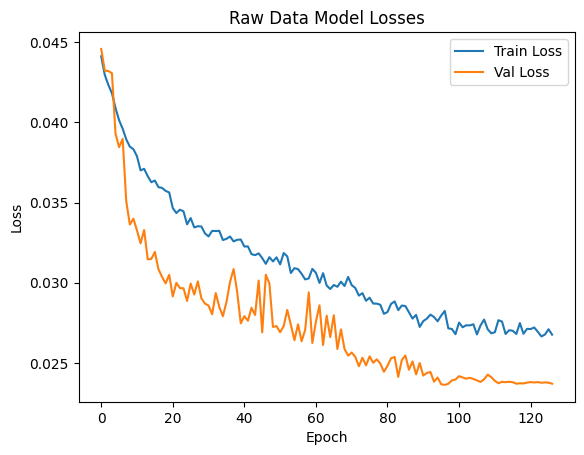

In [130]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

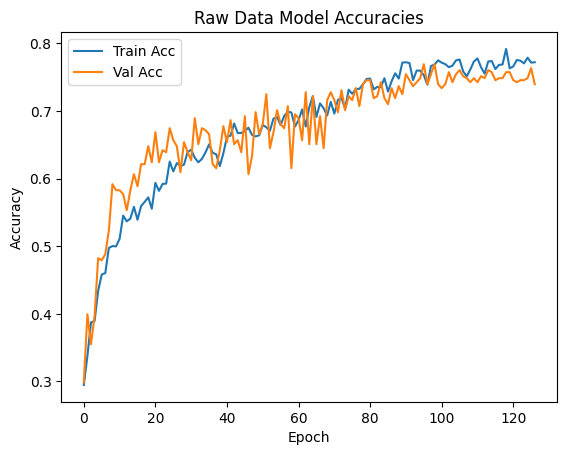

In [131]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Raw Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [138]:
# Load best model and test
raw_model = torch.load("models/cnn/raw.pt")
raw_model.to(device)
raw_model.eval()

CNN(
  (conv_over_time): Sequential(
    (0): Conv2d(1, 20, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
    (1): BatchNorm2d(20, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (conv_over_channels): Sequential(
    (0): Conv2d(20, 48, kernel_size=(22, 1), stride=(1, 1), groups=4, bias=False)
    (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv_by_channel_and_point): Sequential(
    (0): Conv2d(48, 48, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=4, bias=False)
    (1): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.2, inplace=False)
    (6): Co

In [139]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_loader.dataset)
print("Train on raw data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on raw data
Test Acc: 0.6930


In [140]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_sub_loader:
        X, y = X.to(device), y.to(device)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_sub_loader.dataset)
print("Train on raw data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on sub1 data
Test Acc: 0.7400


## Train with augmented data with FT surrogate

In [51]:
device = torch.device('mps')

model = CNN()
model = model.to(device)
print(model)
summary(model, input_size=(1, 22, 1000), device='mps')

CNN(
  (conv_over_time): Sequential(
    (0): Conv2d(1, 24, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (conv_over_channels): Sequential(
    (0): Conv2d(24, 120, kernel_size=(22, 1), stride=(1, 1), groups=8)
    (1): BatchNorm2d(120, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv_by_channel_and_point): Sequential(
    (0): Conv2d(120, 120, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=8)
    (1): Conv2d(120, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 4, kernel_size=(1, 3

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 4]                    --
├─Sequential: 1-1                        [1, 24, 22, 1001]         --
│    └─Conv2d: 2-1                       [1, 24, 22, 1001]         1,560
│    └─BatchNorm2d: 2-2                  [1, 24, 22, 1001]         48
├─Sequential: 1-2                        [1, 120, 1, 250]          --
│    └─Conv2d: 2-3                       [1, 120, 1, 1001]         8,040
│    └─BatchNorm2d: 2-4                  [1, 120, 1, 1001]         240
│    └─ELU: 2-5                          [1, 120, 1, 1001]         --
│    └─AvgPool2d: 2-6                    [1, 120, 1, 250]          --
│    └─Dropout: 2-7                      [1, 120, 1, 250]          --
├─Sequential: 1-3                        [1, 4, 1, 1]              --
│    └─Conv2d: 2-8                       [1, 120, 1, 251]          28,920
│    └─Conv2d: 2-9                       [1, 32, 1, 251]           3,840
│

In [145]:
# aug_model = torch.load("models/cnn/aug_best.pt")
# aug_model.to(device)

CNN(
  (conv_over_time): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (conv_over_channels): Sequential(
    (0): Conv2d(16, 80, kernel_size=(22, 1), stride=(1, 1), groups=8)
    (1): BatchNorm2d(80, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv_by_channel_and_point): Sequential(
    (0): Conv2d(80, 80, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=8)
    (1): Conv2d(80, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(24, 4, kernel_size=(1, 31), s

In [53]:
from utils.training import train

aug_model = model
aug_model.to(device)

optimizer = torch.optim.Adam(aug_model.parameters(), lr=0.001,  weight_decay=0.000001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

tr_loader = train_aug_loader

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=aug_model,
    optimizer=optimizer,
    loss_func=nn.CrossEntropyLoss(),
    train_data=tr_loader,
    val_data=val_loader,
    early_stopping_patience=30,
    scheduler=scheduler,
    cp_path="models/cnn",
    cp_filename="aug.pt",
    n_epochs=150,
    show_progress_bar=True,
)

Using device: mps


Epoch 0: 100%|██████████| 56/56 [00:28<00:00,  1.94batch/s, loss=1.3916]


[Epoch 0] val_acc=0.437870 train_acc=0.449071 val_loss=0.038431 train_loss=0.040566
Validation loss decreased (inf --> 0.038431).  Saving model ...


Epoch 1: 100%|██████████| 56/56 [00:26<00:00,  2.14batch/s, loss=1.3716]


[Epoch 1] val_acc=0.479290 train_acc=0.456950 val_loss=0.037438 train_loss=0.039904
Validation loss decreased (0.038431 --> 0.037438).  Saving model ...


Epoch 2: 100%|██████████| 56/56 [00:27<00:00,  2.07batch/s, loss=1.2319]


[Epoch 2] val_acc=0.482249 train_acc=0.474395 val_loss=0.036799 train_loss=0.039342
Validation loss decreased (0.037438 --> 0.036799).  Saving model ...


Epoch 3: 100%|██████████| 56/56 [00:24<00:00,  2.29batch/s, loss=1.3180]


[Epoch 3] val_acc=0.526627 train_acc=0.484524 val_loss=0.035961 train_loss=0.038611
Validation loss decreased (0.036799 --> 0.035961).  Saving model ...


Epoch 4: 100%|██████████| 56/56 [00:24<00:00,  2.29batch/s, loss=1.0618]


[Epoch 4] val_acc=0.526627 train_acc=0.504221 val_loss=0.035263 train_loss=0.038376
Validation loss decreased (0.035961 --> 0.035263).  Saving model ...


Epoch 5: 100%|██████████| 56/56 [00:27<00:00,  2.05batch/s, loss=1.2126]


[Epoch 5] val_acc=0.541420 train_acc=0.526730 val_loss=0.034525 train_loss=0.037421
Validation loss decreased (0.035263 --> 0.034525).  Saving model ...


Epoch 6: 100%|██████████| 56/56 [00:26<00:00,  2.15batch/s, loss=1.0246]


[Epoch 6] val_acc=0.591716 train_acc=0.530107 val_loss=0.032885 train_loss=0.037392
Validation loss decreased (0.034525 --> 0.032885).  Saving model ...


Epoch 7: 100%|██████████| 56/56 [00:23<00:00,  2.42batch/s, loss=1.1243]


[Epoch 7] val_acc=0.600592 train_acc=0.544176 val_loss=0.031815 train_loss=0.037169
Validation loss decreased (0.032885 --> 0.031815).  Saving model ...


Epoch 8: 100%|██████████| 56/56 [00:26<00:00,  2.14batch/s, loss=1.2442]


[Epoch 8] val_acc=0.591716 train_acc=0.536860 val_loss=0.032163 train_loss=0.036928
EarlyStopping counter: 1 out of 30


Epoch 9: 100%|██████████| 56/56 [00:25<00:00,  2.17batch/s, loss=1.0807]


[Epoch 9] val_acc=0.594675 train_acc=0.551491 val_loss=0.031504 train_loss=0.036356
Validation loss decreased (0.031815 --> 0.031504).  Saving model ...


Epoch 10: 100%|██████████| 56/56 [00:25<00:00,  2.21batch/s, loss=1.1950]


[Epoch 10] val_acc=0.603550 train_acc=0.567811 val_loss=0.030663 train_loss=0.035768
Validation loss decreased (0.031504 --> 0.030663).  Saving model ...


Epoch 11: 100%|██████████| 56/56 [00:24<00:00,  2.32batch/s, loss=1.0097]


[Epoch 11] val_acc=0.639053 train_acc=0.569499 val_loss=0.030205 train_loss=0.035752
Validation loss decreased (0.030663 --> 0.030205).  Saving model ...


Epoch 12: 100%|██████████| 56/56 [00:25<00:00,  2.19batch/s, loss=1.0402]


[Epoch 12] val_acc=0.573964 train_acc=0.571187 val_loss=0.032066 train_loss=0.035241
EarlyStopping counter: 1 out of 30


Epoch 13: 100%|██████████| 56/56 [00:25<00:00,  2.16batch/s, loss=1.1584]


[Epoch 13] val_acc=0.633136 train_acc=0.593134 val_loss=0.031948 train_loss=0.034672
EarlyStopping counter: 2 out of 30


Epoch 14: 100%|██████████| 56/56 [00:25<00:00,  2.23batch/s, loss=0.9823]


[Epoch 14] val_acc=0.644970 train_acc=0.602138 val_loss=0.028850 train_loss=0.034514
Validation loss decreased (0.030205 --> 0.028850).  Saving model ...


Epoch 15: 100%|██████████| 56/56 [00:29<00:00,  1.88batch/s, loss=1.3351]


[Epoch 15] val_acc=0.568047 train_acc=0.589758 val_loss=0.032640 train_loss=0.034873
EarlyStopping counter: 1 out of 30


Epoch 16: 100%|██████████| 56/56 [00:27<00:00,  2.05batch/s, loss=1.4334]


[Epoch 16] val_acc=0.630178 train_acc=0.602701 val_loss=0.030998 train_loss=0.034534
EarlyStopping counter: 2 out of 30


Epoch 17: 100%|██████████| 56/56 [00:26<00:00,  2.10batch/s, loss=1.0777]


[Epoch 17] val_acc=0.627219 train_acc=0.590321 val_loss=0.029622 train_loss=0.034770
EarlyStopping counter: 3 out of 30


Epoch 18: 100%|██████████| 56/56 [00:28<00:00,  1.99batch/s, loss=1.1097]


[Epoch 18] val_acc=0.650888 train_acc=0.608891 val_loss=0.028890 train_loss=0.034399
EarlyStopping counter: 4 out of 30


Epoch 19: 100%|██████████| 56/56 [00:28<00:00,  1.99batch/s, loss=1.2690]


[Epoch 19] val_acc=0.639053 train_acc=0.605515 val_loss=0.029160 train_loss=0.033988
EarlyStopping counter: 5 out of 30


Epoch 20: 100%|██████████| 56/56 [00:28<00:00,  1.93batch/s, loss=0.9037]


[Epoch 20] val_acc=0.636095 train_acc=0.621272 val_loss=0.029389 train_loss=0.033529
EarlyStopping counter: 6 out of 30


Epoch 21: 100%|██████████| 56/56 [00:27<00:00,  2.04batch/s, loss=1.0610]


[Epoch 21] val_acc=0.606509 train_acc=0.616207 val_loss=0.030404 train_loss=0.033641
EarlyStopping counter: 7 out of 30


Epoch 22: 100%|██████████| 56/56 [00:26<00:00,  2.11batch/s, loss=0.9056]


[Epoch 22] val_acc=0.582840 train_acc=0.615644 val_loss=0.030183 train_loss=0.033499
EarlyStopping counter: 8 out of 30


Epoch 23: 100%|██████████| 56/56 [00:28<00:00,  1.97batch/s, loss=1.2428]


[Epoch 23] val_acc=0.642012 train_acc=0.629150 val_loss=0.028921 train_loss=0.033461
EarlyStopping counter: 9 out of 30


Epoch 24: 100%|██████████| 56/56 [00:32<00:00,  1.73batch/s, loss=1.1548]


[Epoch 24] val_acc=0.683432 train_acc=0.637029 val_loss=0.027440 train_loss=0.033083
Validation loss decreased (0.028850 --> 0.027440).  Saving model ...


Epoch 25: 100%|██████████| 56/56 [00:28<00:00,  1.99batch/s, loss=0.9946]


[Epoch 25] val_acc=0.698225 train_acc=0.634778 val_loss=0.026961 train_loss=0.032867
Validation loss decreased (0.027440 --> 0.026961).  Saving model ...


Epoch 26: 100%|██████████| 56/56 [00:26<00:00,  2.14batch/s, loss=0.9707]


[Epoch 26] val_acc=0.621302 train_acc=0.640405 val_loss=0.030614 train_loss=0.033457
EarlyStopping counter: 1 out of 30


Epoch 27: 100%|██████████| 56/56 [00:26<00:00,  2.15batch/s, loss=0.9363]


[Epoch 27] val_acc=0.671598 train_acc=0.649409 val_loss=0.028692 train_loss=0.032584
EarlyStopping counter: 2 out of 30


Epoch 28: 100%|██████████| 56/56 [00:24<00:00,  2.31batch/s, loss=0.9765]


[Epoch 28] val_acc=0.612426 train_acc=0.641531 val_loss=0.029674 train_loss=0.032349
EarlyStopping counter: 3 out of 30


Epoch 29: 100%|██████████| 56/56 [00:26<00:00,  2.13batch/s, loss=0.9785]


[Epoch 29] val_acc=0.671598 train_acc=0.633652 val_loss=0.027350 train_loss=0.032693
EarlyStopping counter: 4 out of 30


Epoch 30: 100%|██████████| 56/56 [00:25<00:00,  2.19batch/s, loss=1.0958]


[Epoch 30] val_acc=0.653846 train_acc=0.646033 val_loss=0.028519 train_loss=0.032401
EarlyStopping counter: 5 out of 30


Epoch 31: 100%|██████████| 56/56 [00:27<00:00,  2.00batch/s, loss=0.9004]


[Epoch 31] val_acc=0.650888 train_acc=0.642656 val_loss=0.027855 train_loss=0.032364
EarlyStopping counter: 6 out of 30


Epoch 32: 100%|██████████| 56/56 [00:32<00:00,  1.71batch/s, loss=1.1044]


[Epoch 32] val_acc=0.680473 train_acc=0.661790 val_loss=0.027311 train_loss=0.032223
EarlyStopping counter: 7 out of 30


Epoch 33: 100%|██████████| 56/56 [00:27<00:00,  2.02batch/s, loss=1.0110]


[Epoch 33] val_acc=0.701183 train_acc=0.671356 val_loss=0.026498 train_loss=0.031900
Validation loss decreased (0.026961 --> 0.026498).  Saving model ...


Epoch 34: 100%|██████████| 56/56 [00:27<00:00,  2.01batch/s, loss=1.0567]


[Epoch 34] val_acc=0.644970 train_acc=0.670231 val_loss=0.028194 train_loss=0.031926
EarlyStopping counter: 1 out of 30


Epoch 35: 100%|██████████| 56/56 [00:28<00:00,  1.98batch/s, loss=1.0093]


[Epoch 35] val_acc=0.653846 train_acc=0.668542 val_loss=0.028734 train_loss=0.031280
EarlyStopping counter: 2 out of 30


Epoch 36: 100%|██████████| 56/56 [00:30<00:00,  1.85batch/s, loss=0.8188]


[Epoch 36] val_acc=0.674556 train_acc=0.682048 val_loss=0.027055 train_loss=0.030965
EarlyStopping counter: 3 out of 30


Epoch 37: 100%|██████████| 56/56 [00:26<00:00,  2.11batch/s, loss=1.0426]


[Epoch 37] val_acc=0.665680 train_acc=0.670231 val_loss=0.026960 train_loss=0.031705
EarlyStopping counter: 4 out of 30


Epoch 38: 100%|██████████| 56/56 [00:26<00:00,  2.11batch/s, loss=1.0863]


[Epoch 38] val_acc=0.674556 train_acc=0.683737 val_loss=0.026524 train_loss=0.031181
EarlyStopping counter: 5 out of 30


Epoch 39: 100%|██████████| 56/56 [00:26<00:00,  2.11batch/s, loss=1.0485]


[Epoch 39] val_acc=0.636095 train_acc=0.686550 val_loss=0.027449 train_loss=0.031134
EarlyStopping counter: 6 out of 30


Epoch 40: 100%|██████████| 56/56 [00:26<00:00,  2.10batch/s, loss=0.9512]


[Epoch 40] val_acc=0.636095 train_acc=0.666854 val_loss=0.028535 train_loss=0.031637
EarlyStopping counter: 7 out of 30


Epoch 41: 100%|██████████| 56/56 [00:27<00:00,  2.05batch/s, loss=1.0609]


[Epoch 41] val_acc=0.644970 train_acc=0.688239 val_loss=0.027343 train_loss=0.031079
EarlyStopping counter: 8 out of 30


Epoch 42: 100%|██████████| 56/56 [00:26<00:00,  2.08batch/s, loss=0.9950]


[Epoch 42] val_acc=0.683432 train_acc=0.690490 val_loss=0.027259 train_loss=0.030884
EarlyStopping counter: 9 out of 30


Epoch 43: 100%|██████████| 56/56 [00:28<00:00,  1.96batch/s, loss=0.8756]


[Epoch 43] val_acc=0.677515 train_acc=0.681486 val_loss=0.026735 train_loss=0.030997
EarlyStopping counter: 10 out of 30


Epoch 44: 100%|██████████| 56/56 [00:24<00:00,  2.29batch/s, loss=0.9265]


[Epoch 44] val_acc=0.701183 train_acc=0.692741 val_loss=0.026074 train_loss=0.030511
Validation loss decreased (0.026498 --> 0.026074).  Saving model ...


Epoch 45: 100%|██████████| 56/56 [00:28<00:00,  1.94batch/s, loss=0.7897]


[Epoch 45] val_acc=0.642012 train_acc=0.688239 val_loss=0.027691 train_loss=0.030643
EarlyStopping counter: 1 out of 30


Epoch 46: 100%|██████████| 56/56 [00:28<00:00,  1.94batch/s, loss=0.8853]


[Epoch 46] val_acc=0.659763 train_acc=0.689927 val_loss=0.027994 train_loss=0.030510
EarlyStopping counter: 2 out of 30


Epoch 47: 100%|██████████| 56/56 [00:29<00:00,  1.92batch/s, loss=0.9266]


[Epoch 47] val_acc=0.674556 train_acc=0.694429 val_loss=0.027410 train_loss=0.030431
EarlyStopping counter: 3 out of 30


Epoch 48: 100%|██████████| 56/56 [00:25<00:00,  2.19batch/s, loss=1.0387]


[Epoch 48] val_acc=0.653846 train_acc=0.686550 val_loss=0.027220 train_loss=0.030294
EarlyStopping counter: 4 out of 30


Epoch 49: 100%|██████████| 56/56 [00:26<00:00,  2.12batch/s, loss=0.9350]


[Epoch 49] val_acc=0.674556 train_acc=0.693866 val_loss=0.026217 train_loss=0.030780
EarlyStopping counter: 5 out of 30


Epoch 50: 100%|██████████| 56/56 [00:25<00:00,  2.19batch/s, loss=0.9037]


[Epoch 50] val_acc=0.665680 train_acc=0.715813 val_loss=0.026576 train_loss=0.029650
EarlyStopping counter: 6 out of 30


Epoch 51: 100%|██████████| 56/56 [00:26<00:00,  2.13batch/s, loss=0.9257]


[Epoch 51] val_acc=0.701183 train_acc=0.700056 val_loss=0.027215 train_loss=0.029900
EarlyStopping counter: 7 out of 30


Epoch 52: 100%|██████████| 56/56 [00:25<00:00,  2.20batch/s, loss=1.1788]


[Epoch 52] val_acc=0.639053 train_acc=0.709060 val_loss=0.029119 train_loss=0.029975
EarlyStopping counter: 8 out of 30


Epoch 53: 100%|██████████| 56/56 [00:29<00:00,  1.93batch/s, loss=1.0736]


[Epoch 53] val_acc=0.680473 train_acc=0.684862 val_loss=0.027784 train_loss=0.030767
EarlyStopping counter: 9 out of 30


Epoch 54: 100%|██████████| 56/56 [00:33<00:00,  1.68batch/s, loss=0.9601]


[Epoch 54] val_acc=0.680473 train_acc=0.713562 val_loss=0.026002 train_loss=0.029869
Validation loss decreased (0.026074 --> 0.026002).  Saving model ...


Epoch 55: 100%|██████████| 56/56 [00:30<00:00,  1.86batch/s, loss=1.0724]


[Epoch 55] val_acc=0.686391 train_acc=0.709060 val_loss=0.026167 train_loss=0.030088
EarlyStopping counter: 1 out of 30


Epoch 56: 100%|██████████| 56/56 [00:31<00:00,  1.77batch/s, loss=0.9723]


[Epoch 56] val_acc=0.680473 train_acc=0.703995 val_loss=0.026368 train_loss=0.029840
EarlyStopping counter: 2 out of 30


Epoch 57: 100%|██████████| 56/56 [00:29<00:00,  1.88batch/s, loss=0.8618]


[Epoch 57] val_acc=0.680473 train_acc=0.736635 val_loss=0.026540 train_loss=0.028747
EarlyStopping counter: 3 out of 30


Epoch 58: 100%|██████████| 56/56 [00:27<00:00,  2.00batch/s, loss=0.9685]


[Epoch 58] val_acc=0.689349 train_acc=0.758019 val_loss=0.025864 train_loss=0.028353
Validation loss decreased (0.026002 --> 0.025864).  Saving model ...


Epoch 59: 100%|██████████| 56/56 [00:28<00:00,  1.95batch/s, loss=1.1099]


[Epoch 59] val_acc=0.698225 train_acc=0.722566 val_loss=0.026066 train_loss=0.029192
EarlyStopping counter: 1 out of 30


Epoch 60: 100%|██████████| 56/56 [00:28<00:00,  1.95batch/s, loss=0.9857]


[Epoch 60] val_acc=0.715976 train_acc=0.740011 val_loss=0.024895 train_loss=0.028433
Validation loss decreased (0.025864 --> 0.024895).  Saving model ...


Epoch 61: 100%|██████████| 56/56 [00:28<00:00,  1.95batch/s, loss=0.8221]


[Epoch 61] val_acc=0.710059 train_acc=0.748452 val_loss=0.025085 train_loss=0.028618
EarlyStopping counter: 1 out of 30


Epoch 62: 100%|██████████| 56/56 [00:28<00:00,  1.94batch/s, loss=0.9498]


[Epoch 62] val_acc=0.713018 train_acc=0.732696 val_loss=0.025873 train_loss=0.028296
EarlyStopping counter: 2 out of 30


Epoch 63: 100%|██████████| 56/56 [00:30<00:00,  1.84batch/s, loss=0.8558]


[Epoch 63] val_acc=0.698225 train_acc=0.748452 val_loss=0.026015 train_loss=0.027976
EarlyStopping counter: 3 out of 30


Epoch 64: 100%|██████████| 56/56 [00:28<00:00,  1.97batch/s, loss=1.1648]


[Epoch 64] val_acc=0.718935 train_acc=0.732133 val_loss=0.025385 train_loss=0.028794
EarlyStopping counter: 4 out of 30


Epoch 65: 100%|██████████| 56/56 [00:30<00:00,  1.82batch/s, loss=0.8084]


[Epoch 65] val_acc=0.695266 train_acc=0.751266 val_loss=0.025725 train_loss=0.028200
EarlyStopping counter: 5 out of 30


Epoch 66: 100%|██████████| 56/56 [00:28<00:00,  1.94batch/s, loss=1.0045]


[Epoch 66] val_acc=0.695266 train_acc=0.742825 val_loss=0.025640 train_loss=0.027705
EarlyStopping counter: 6 out of 30


Epoch 67: 100%|██████████| 56/56 [00:28<00:00,  1.95batch/s, loss=0.8910]


[Epoch 67] val_acc=0.707101 train_acc=0.736072 val_loss=0.024878 train_loss=0.028549
Validation loss decreased (0.024895 --> 0.024878).  Saving model ...


Epoch 68: 100%|██████████| 56/56 [00:27<00:00,  2.03batch/s, loss=0.9461]


[Epoch 68] val_acc=0.704142 train_acc=0.760833 val_loss=0.024818 train_loss=0.027756
Validation loss decreased (0.024878 --> 0.024818).  Saving model ...


Epoch 69: 100%|██████████| 56/56 [00:27<00:00,  2.03batch/s, loss=1.1088]


[Epoch 69] val_acc=0.713018 train_acc=0.746764 val_loss=0.025336 train_loss=0.027855
EarlyStopping counter: 1 out of 30


Epoch 70: 100%|██████████| 56/56 [00:26<00:00,  2.12batch/s, loss=0.8690]


[Epoch 70] val_acc=0.650888 train_acc=0.774902 val_loss=0.027223 train_loss=0.027459
EarlyStopping counter: 2 out of 30


Epoch 71: 100%|██████████| 56/56 [00:27<00:00,  2.03batch/s, loss=0.7659]


[Epoch 71] val_acc=0.739645 train_acc=0.761396 val_loss=0.024317 train_loss=0.027630
Validation loss decreased (0.024818 --> 0.024317).  Saving model ...


Epoch 72: 100%|██████████| 56/56 [00:28<00:00,  1.98batch/s, loss=0.7704]


[Epoch 72] val_acc=0.718935 train_acc=0.754643 val_loss=0.024606 train_loss=0.027532
EarlyStopping counter: 1 out of 30


Epoch 73: 100%|██████████| 56/56 [00:28<00:00,  2.00batch/s, loss=0.8249]


[Epoch 73] val_acc=0.724852 train_acc=0.759707 val_loss=0.024434 train_loss=0.027615
EarlyStopping counter: 2 out of 30


Epoch 74: 100%|██████████| 56/56 [00:30<00:00,  1.81batch/s, loss=0.9994]


[Epoch 74] val_acc=0.704142 train_acc=0.751266 val_loss=0.025314 train_loss=0.027899
EarlyStopping counter: 3 out of 30


Epoch 75: 100%|██████████| 56/56 [00:28<00:00,  1.96batch/s, loss=1.0547]


[Epoch 75] val_acc=0.718935 train_acc=0.735509 val_loss=0.024933 train_loss=0.028638
EarlyStopping counter: 4 out of 30


Epoch 76: 100%|██████████| 56/56 [00:28<00:00,  1.99batch/s, loss=0.8242]


[Epoch 76] val_acc=0.692308 train_acc=0.768149 val_loss=0.026233 train_loss=0.027843
EarlyStopping counter: 5 out of 30


Epoch 77: 100%|██████████| 56/56 [00:28<00:00,  2.00batch/s, loss=0.9593]


[Epoch 77] val_acc=0.730769 train_acc=0.769837 val_loss=0.024789 train_loss=0.027181
EarlyStopping counter: 6 out of 30


Epoch 78: 100%|██████████| 56/56 [00:28<00:00,  1.98batch/s, loss=0.7910]


[Epoch 78] val_acc=0.707101 train_acc=0.770400 val_loss=0.025187 train_loss=0.026905
EarlyStopping counter: 7 out of 30


Epoch 79: 100%|██████████| 56/56 [00:27<00:00,  2.02batch/s, loss=0.9559]


[Epoch 79] val_acc=0.724852 train_acc=0.772088 val_loss=0.024536 train_loss=0.026806
EarlyStopping counter: 8 out of 30


Epoch 80: 100%|██████████| 56/56 [00:28<00:00,  1.94batch/s, loss=0.8513]


[Epoch 80] val_acc=0.718935 train_acc=0.771525 val_loss=0.024529 train_loss=0.027033
EarlyStopping counter: 9 out of 30


Epoch 81: 100%|██████████| 56/56 [00:29<00:00,  1.88batch/s, loss=1.0416]


[Epoch 81] val_acc=0.727811 train_acc=0.785031 val_loss=0.024388 train_loss=0.026783
EarlyStopping counter: 10 out of 30


Epoch 82: 100%|██████████| 56/56 [00:29<00:00,  1.87batch/s, loss=0.9523]


[Epoch 82] val_acc=0.721893 train_acc=0.777715 val_loss=0.024470 train_loss=0.027005
EarlyStopping counter: 11 out of 30


Epoch 83: 100%|██████████| 56/56 [00:32<00:00,  1.72batch/s, loss=0.7327]


[Epoch 83] val_acc=0.727811 train_acc=0.779966 val_loss=0.024561 train_loss=0.026629
EarlyStopping counter: 12 out of 30


Epoch 84: 100%|██████████| 56/56 [00:29<00:00,  1.87batch/s, loss=0.8045]


[Epoch 84] val_acc=0.727811 train_acc=0.764209 val_loss=0.023924 train_loss=0.026929
Validation loss decreased (0.024317 --> 0.023924).  Saving model ...


Epoch 85: 100%|██████████| 56/56 [00:31<00:00,  1.80batch/s, loss=0.8661]


[Epoch 85] val_acc=0.721893 train_acc=0.782780 val_loss=0.024446 train_loss=0.027140
EarlyStopping counter: 1 out of 30


Epoch 86: 100%|██████████| 56/56 [00:29<00:00,  1.88batch/s, loss=1.0283]


[Epoch 86] val_acc=0.710059 train_acc=0.785594 val_loss=0.024800 train_loss=0.026307
EarlyStopping counter: 2 out of 30


Epoch 87: 100%|██████████| 56/56 [00:28<00:00,  1.96batch/s, loss=0.9520]


[Epoch 87] val_acc=0.736686 train_acc=0.776590 val_loss=0.024327 train_loss=0.027182
EarlyStopping counter: 3 out of 30


Epoch 88: 100%|██████████| 56/56 [00:28<00:00,  1.99batch/s, loss=0.9207]


[Epoch 88] val_acc=0.727811 train_acc=0.776027 val_loss=0.024126 train_loss=0.026476
EarlyStopping counter: 4 out of 30


Epoch 89: 100%|██████████| 56/56 [00:29<00:00,  1.91batch/s, loss=0.9855]


[Epoch 89] val_acc=0.704142 train_acc=0.783343 val_loss=0.024254 train_loss=0.026592
EarlyStopping counter: 5 out of 30


Epoch 90: 100%|██████████| 56/56 [00:28<00:00,  1.99batch/s, loss=0.7502]


[Epoch 90] val_acc=0.724852 train_acc=0.796849 val_loss=0.024092 train_loss=0.026166
EarlyStopping counter: 6 out of 30


Epoch 91: 100%|██████████| 56/56 [00:32<00:00,  1.71batch/s, loss=0.8613]


[Epoch 91] val_acc=0.736686 train_acc=0.783905 val_loss=0.023784 train_loss=0.026642
Validation loss decreased (0.023924 --> 0.023784).  Saving model ...


Epoch 92: 100%|██████████| 56/56 [00:36<00:00,  1.55batch/s, loss=0.8144]


[Epoch 92] val_acc=0.713018 train_acc=0.795723 val_loss=0.024075 train_loss=0.026391
EarlyStopping counter: 1 out of 30


Epoch 93: 100%|██████████| 56/56 [00:29<00:00,  1.87batch/s, loss=1.0452]


[Epoch 93] val_acc=0.724852 train_acc=0.792909 val_loss=0.023767 train_loss=0.026718
Validation loss decreased (0.023784 --> 0.023767).  Saving model ...


Epoch 94: 100%|██████████| 56/56 [00:33<00:00,  1.68batch/s, loss=0.8253]


[Epoch 94] val_acc=0.727811 train_acc=0.786156 val_loss=0.024121 train_loss=0.026744
EarlyStopping counter: 1 out of 30


Epoch 95: 100%|██████████| 56/56 [00:29<00:00,  1.87batch/s, loss=0.7725]


[Epoch 95] val_acc=0.727811 train_acc=0.775464 val_loss=0.023749 train_loss=0.027022
Validation loss decreased (0.023767 --> 0.023749).  Saving model ...


Epoch 96: 100%|██████████| 56/56 [00:31<00:00,  1.78batch/s, loss=0.7323]


[Epoch 96] val_acc=0.689349 train_acc=0.775464 val_loss=0.024371 train_loss=0.026654
EarlyStopping counter: 1 out of 30


Epoch 97: 100%|██████████| 56/56 [00:29<00:00,  1.89batch/s, loss=0.8044]


[Epoch 97] val_acc=0.748521 train_acc=0.790658 val_loss=0.024023 train_loss=0.026244
EarlyStopping counter: 2 out of 30


Epoch 98: 100%|██████████| 56/56 [00:30<00:00,  1.85batch/s, loss=0.8638]


[Epoch 98] val_acc=0.745562 train_acc=0.788407 val_loss=0.023864 train_loss=0.026242
EarlyStopping counter: 3 out of 30


Epoch 99: 100%|██████████| 56/56 [00:31<00:00,  1.76batch/s, loss=0.8130]


[Epoch 99] val_acc=0.733728 train_acc=0.796849 val_loss=0.024000 train_loss=0.026192
EarlyStopping counter: 4 out of 30


Epoch 100: 100%|██████████| 56/56 [00:29<00:00,  1.91batch/s, loss=0.8264]


[Epoch 100] val_acc=0.745562 train_acc=0.798537 val_loss=0.023762 train_loss=0.026482
EarlyStopping counter: 5 out of 30


Epoch 101: 100%|██████████| 56/56 [00:30<00:00,  1.86batch/s, loss=0.7427]


[Epoch 101] val_acc=0.742604 train_acc=0.776590 val_loss=0.023864 train_loss=0.026515
EarlyStopping counter: 6 out of 30


Epoch 102: 100%|██████████| 56/56 [00:31<00:00,  1.77batch/s, loss=0.9124]


[Epoch 102] val_acc=0.724852 train_acc=0.797411 val_loss=0.023935 train_loss=0.025987
EarlyStopping counter: 7 out of 30


Epoch 103: 100%|██████████| 56/56 [00:33<00:00,  1.67batch/s, loss=0.9159]


[Epoch 103] val_acc=0.748521 train_acc=0.796286 val_loss=0.023695 train_loss=0.025769
Validation loss decreased (0.023749 --> 0.023695).  Saving model ...


Epoch 104: 100%|██████████| 56/56 [00:29<00:00,  1.88batch/s, loss=0.8368]


[Epoch 104] val_acc=0.742604 train_acc=0.791784 val_loss=0.023575 train_loss=0.026285
Validation loss decreased (0.023695 --> 0.023575).  Saving model ...


Epoch 105: 100%|██████████| 56/56 [00:29<00:00,  1.87batch/s, loss=0.8744]


[Epoch 105] val_acc=0.748521 train_acc=0.805853 val_loss=0.023849 train_loss=0.025982
EarlyStopping counter: 1 out of 30


Epoch 106: 100%|██████████| 56/56 [00:28<00:00,  1.94batch/s, loss=0.7973]


[Epoch 106] val_acc=0.742604 train_acc=0.798537 val_loss=0.023725 train_loss=0.025918
EarlyStopping counter: 2 out of 30


Epoch 107: 100%|██████████| 56/56 [00:33<00:00,  1.68batch/s, loss=0.7223]


[Epoch 107] val_acc=0.736686 train_acc=0.806415 val_loss=0.023617 train_loss=0.025300
EarlyStopping counter: 3 out of 30


Epoch 108: 100%|██████████| 56/56 [00:29<00:00,  1.92batch/s, loss=0.8036]


[Epoch 108] val_acc=0.739645 train_acc=0.787282 val_loss=0.023698 train_loss=0.026135
EarlyStopping counter: 4 out of 30


Epoch 109: 100%|██████████| 56/56 [00:35<00:00,  1.59batch/s, loss=0.9262]


[Epoch 109] val_acc=0.754438 train_acc=0.795723 val_loss=0.023385 train_loss=0.025911
Validation loss decreased (0.023575 --> 0.023385).  Saving model ...


Epoch 110: 100%|██████████| 56/56 [00:34<00:00,  1.65batch/s, loss=0.6383]


[Epoch 110] val_acc=0.745562 train_acc=0.811480 val_loss=0.023425 train_loss=0.025491
EarlyStopping counter: 1 out of 30


Epoch 111: 100%|██████████| 56/56 [00:30<00:00,  1.84batch/s, loss=0.8081]


[Epoch 111] val_acc=0.742604 train_acc=0.788970 val_loss=0.023580 train_loss=0.025878
EarlyStopping counter: 2 out of 30


Epoch 112: 100%|██████████| 56/56 [00:29<00:00,  1.89batch/s, loss=0.9466]


[Epoch 112] val_acc=0.754438 train_acc=0.791221 val_loss=0.023472 train_loss=0.026040
EarlyStopping counter: 3 out of 30


Epoch 113: 100%|██████████| 56/56 [00:29<00:00,  1.87batch/s, loss=0.8031]


[Epoch 113] val_acc=0.757396 train_acc=0.791784 val_loss=0.023604 train_loss=0.026001
EarlyStopping counter: 4 out of 30


Epoch 114: 100%|██████████| 56/56 [00:31<00:00,  1.80batch/s, loss=0.8114]


[Epoch 114] val_acc=0.748521 train_acc=0.779403 val_loss=0.023736 train_loss=0.026296
EarlyStopping counter: 5 out of 30


Epoch 115: 100%|██████████| 56/56 [00:30<00:00,  1.83batch/s, loss=0.7879]


[Epoch 115] val_acc=0.739645 train_acc=0.814856 val_loss=0.023544 train_loss=0.025427
EarlyStopping counter: 6 out of 30


Epoch 116: 100%|██████████| 56/56 [00:30<00:00,  1.83batch/s, loss=0.8233]


[Epoch 116] val_acc=0.739645 train_acc=0.792909 val_loss=0.023539 train_loss=0.025839
EarlyStopping counter: 7 out of 30


Epoch 117: 100%|██████████| 56/56 [00:31<00:00,  1.77batch/s, loss=0.8146]


[Epoch 117] val_acc=0.736686 train_acc=0.806415 val_loss=0.023405 train_loss=0.025771
EarlyStopping counter: 8 out of 30


Epoch 118: 100%|██████████| 56/56 [00:34<00:00,  1.60batch/s, loss=0.7674]


[Epoch 118] val_acc=0.742604 train_acc=0.801351 val_loss=0.023425 train_loss=0.025827
EarlyStopping counter: 9 out of 30


Epoch 119: 100%|██████████| 56/56 [00:35<00:00,  1.59batch/s, loss=0.7528]


[Epoch 119] val_acc=0.745562 train_acc=0.805290 val_loss=0.023348 train_loss=0.025643
Validation loss decreased (0.023385 --> 0.023348).  Saving model ...


Epoch 120: 100%|██████████| 56/56 [00:30<00:00,  1.85batch/s, loss=0.8321]


[Epoch 120] val_acc=0.742604 train_acc=0.807541 val_loss=0.023417 train_loss=0.025436
EarlyStopping counter: 1 out of 30


Epoch 121: 100%|██████████| 56/56 [00:29<00:00,  1.90batch/s, loss=0.6184]


[Epoch 121] val_acc=0.745562 train_acc=0.817670 val_loss=0.023434 train_loss=0.025565
EarlyStopping counter: 2 out of 30


Epoch 122: 100%|██████████| 56/56 [00:29<00:00,  1.91batch/s, loss=0.6832]


[Epoch 122] val_acc=0.742604 train_acc=0.794035 val_loss=0.023462 train_loss=0.025975
EarlyStopping counter: 3 out of 30


Epoch 123: 100%|██████████| 56/56 [00:28<00:00,  1.97batch/s, loss=0.7715]


[Epoch 123] val_acc=0.736686 train_acc=0.794035 val_loss=0.023368 train_loss=0.025706
EarlyStopping counter: 4 out of 30


Epoch 124: 100%|██████████| 56/56 [00:29<00:00,  1.87batch/s, loss=0.7569]


[Epoch 124] val_acc=0.739645 train_acc=0.812043 val_loss=0.023392 train_loss=0.025154
EarlyStopping counter: 5 out of 30


Epoch 125: 100%|██████████| 56/56 [00:33<00:00,  1.70batch/s, loss=0.7841]


[Epoch 125] val_acc=0.739645 train_acc=0.802476 val_loss=0.023373 train_loss=0.025692
EarlyStopping counter: 6 out of 30


Epoch 126: 100%|██████████| 56/56 [00:29<00:00,  1.91batch/s, loss=0.8603]


[Epoch 126] val_acc=0.754438 train_acc=0.813168 val_loss=0.023457 train_loss=0.025542
EarlyStopping counter: 7 out of 30


Epoch 127: 100%|██████████| 56/56 [00:29<00:00,  1.93batch/s, loss=0.7475]


[Epoch 127] val_acc=0.751479 train_acc=0.812606 val_loss=0.023405 train_loss=0.025454
EarlyStopping counter: 8 out of 30


Epoch 128: 100%|██████████| 56/56 [00:28<00:00,  1.93batch/s, loss=1.1341]


[Epoch 128] val_acc=0.745562 train_acc=0.804164 val_loss=0.023404 train_loss=0.025696
EarlyStopping counter: 9 out of 30


Epoch 129: 100%|██████████| 56/56 [00:29<00:00,  1.91batch/s, loss=1.0016]


[Epoch 129] val_acc=0.742604 train_acc=0.814294 val_loss=0.023396 train_loss=0.025795
EarlyStopping counter: 10 out of 30


Epoch 130: 100%|██████████| 56/56 [00:29<00:00,  1.92batch/s, loss=0.7974]


[Epoch 130] val_acc=0.745562 train_acc=0.805290 val_loss=0.023397 train_loss=0.025616
EarlyStopping counter: 11 out of 30


Epoch 131: 100%|██████████| 56/56 [00:32<00:00,  1.72batch/s, loss=1.0307]


[Epoch 131] val_acc=0.739645 train_acc=0.807541 val_loss=0.023315 train_loss=0.025604
Validation loss decreased (0.023348 --> 0.023315).  Saving model ...


Epoch 132: 100%|██████████| 56/56 [00:31<00:00,  1.80batch/s, loss=0.8317]


[Epoch 132] val_acc=0.745562 train_acc=0.806415 val_loss=0.023347 train_loss=0.025311
EarlyStopping counter: 1 out of 30


Epoch 133: 100%|██████████| 56/56 [00:26<00:00,  2.08batch/s, loss=0.8080]


[Epoch 133] val_acc=0.745562 train_acc=0.792347 val_loss=0.023314 train_loss=0.025681
EarlyStopping counter: 2 out of 30


Epoch 134: 100%|██████████| 56/56 [00:25<00:00,  2.20batch/s, loss=0.7548]


[Epoch 134] val_acc=0.742604 train_acc=0.801913 val_loss=0.023305 train_loss=0.025574
Validation loss decreased (0.023315 --> 0.023305).  Saving model ...


Epoch 135: 100%|██████████| 56/56 [00:25<00:00,  2.18batch/s, loss=0.9912]


[Epoch 135] val_acc=0.745562 train_acc=0.794598 val_loss=0.023371 train_loss=0.026097
EarlyStopping counter: 1 out of 30


Epoch 136: 100%|██████████| 56/56 [00:25<00:00,  2.19batch/s, loss=0.6962]


[Epoch 136] val_acc=0.745562 train_acc=0.815982 val_loss=0.023350 train_loss=0.025739
EarlyStopping counter: 2 out of 30


Epoch 137: 100%|██████████| 56/56 [00:25<00:00,  2.20batch/s, loss=0.8718]


[Epoch 137] val_acc=0.745562 train_acc=0.818796 val_loss=0.023354 train_loss=0.025470
EarlyStopping counter: 3 out of 30


Epoch 138: 100%|██████████| 56/56 [00:25<00:00,  2.20batch/s, loss=0.8261]


[Epoch 138] val_acc=0.745562 train_acc=0.803039 val_loss=0.023404 train_loss=0.025751
EarlyStopping counter: 4 out of 30


Epoch 139: 100%|██████████| 56/56 [00:25<00:00,  2.19batch/s, loss=0.7627]


[Epoch 139] val_acc=0.745562 train_acc=0.804164 val_loss=0.023377 train_loss=0.025752
EarlyStopping counter: 5 out of 30


Epoch 140: 100%|██████████| 56/56 [00:25<00:00,  2.19batch/s, loss=0.8961]


[Epoch 140] val_acc=0.745562 train_acc=0.800788 val_loss=0.023379 train_loss=0.025622
EarlyStopping counter: 6 out of 30


Epoch 141: 100%|██████████| 56/56 [00:27<00:00,  2.01batch/s, loss=0.8400]


[Epoch 141] val_acc=0.745562 train_acc=0.796286 val_loss=0.023377 train_loss=0.025959
EarlyStopping counter: 7 out of 30


Epoch 142: 100%|██████████| 56/56 [00:25<00:00,  2.21batch/s, loss=0.8214]


[Epoch 142] val_acc=0.745562 train_acc=0.805290 val_loss=0.023383 train_loss=0.025299
EarlyStopping counter: 8 out of 30


Epoch 143: 100%|██████████| 56/56 [00:25<00:00,  2.16batch/s, loss=0.9316]


[Epoch 143] val_acc=0.745562 train_acc=0.803039 val_loss=0.023364 train_loss=0.025810
EarlyStopping counter: 9 out of 30


Epoch 144: 100%|██████████| 56/56 [00:26<00:00,  2.12batch/s, loss=0.7585]


[Epoch 144] val_acc=0.745562 train_acc=0.811480 val_loss=0.023372 train_loss=0.025766
EarlyStopping counter: 10 out of 30


Epoch 145: 100%|██████████| 56/56 [00:26<00:00,  2.13batch/s, loss=0.6456]


[Epoch 145] val_acc=0.742604 train_acc=0.790658 val_loss=0.023388 train_loss=0.025676
EarlyStopping counter: 11 out of 30


Epoch 146: 100%|██████████| 56/56 [00:28<00:00,  1.93batch/s, loss=0.7477]


[Epoch 146] val_acc=0.745562 train_acc=0.805290 val_loss=0.023358 train_loss=0.025732
EarlyStopping counter: 12 out of 30


Epoch 147: 100%|██████████| 56/56 [00:25<00:00,  2.17batch/s, loss=0.7838]


[Epoch 147] val_acc=0.742604 train_acc=0.795160 val_loss=0.023363 train_loss=0.025771
EarlyStopping counter: 13 out of 30


Epoch 148: 100%|██████████| 56/56 [00:28<00:00,  1.94batch/s, loss=0.7514]


[Epoch 148] val_acc=0.742604 train_acc=0.797411 val_loss=0.023353 train_loss=0.026122
EarlyStopping counter: 14 out of 30


Epoch 149: 100%|██████████| 56/56 [00:27<00:00,  2.06batch/s, loss=1.2975]


[Epoch 149] val_acc=0.742604 train_acc=0.795160 val_loss=0.023335 train_loss=0.026046
EarlyStopping counter: 15 out of 30


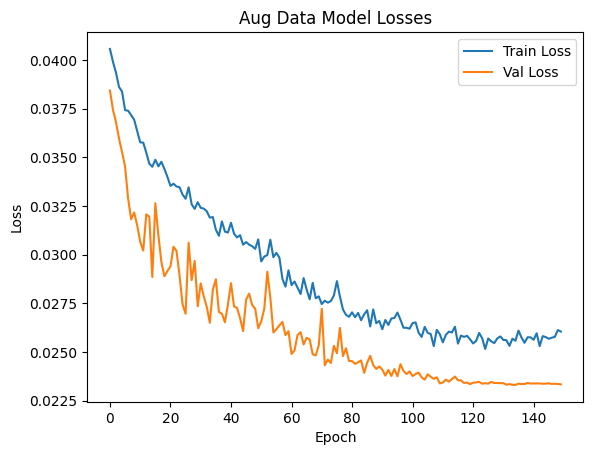

In [54]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Aug Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

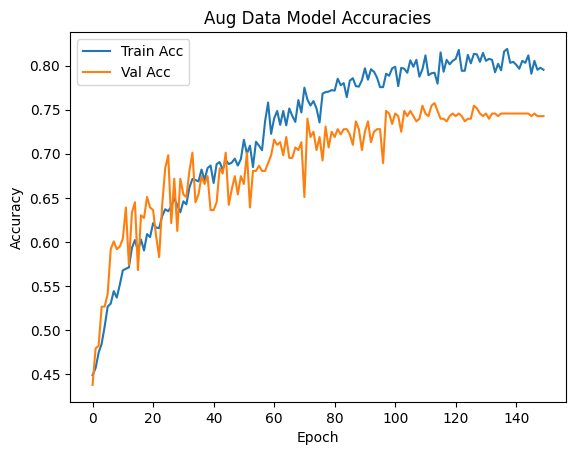

In [55]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Aug Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [69]:
# Load best model and test
aug_model = torch.load("models/cnn/aug_7201.pt")
aug_model.to(device)
aug_model.eval()

CNN(
  (conv_over_time): Sequential(
    (0): Conv2d(1, 24, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (conv_over_channels): Sequential(
    (0): Conv2d(24, 120, kernel_size=(22, 1), stride=(1, 1), groups=8)
    (1): BatchNorm2d(120, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv_by_channel_and_point): Sequential(
    (0): Conv2d(120, 120, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=8)
    (1): Conv2d(120, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 4, kernel_size=(1, 3

In [70]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = aug_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_loader.dataset)
print("Train on aug data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on aug data, evaluate on raw data
Test Acc: 0.7201


In [71]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_sub_loader:
        X, y = X.to(device), y.to(device)
        y_pred = aug_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_sub_loader.dataset)
print("Train on raw data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on sub1 data
Test Acc: 0.7200


## Train on FT Surrogate and Smooth Time Mask

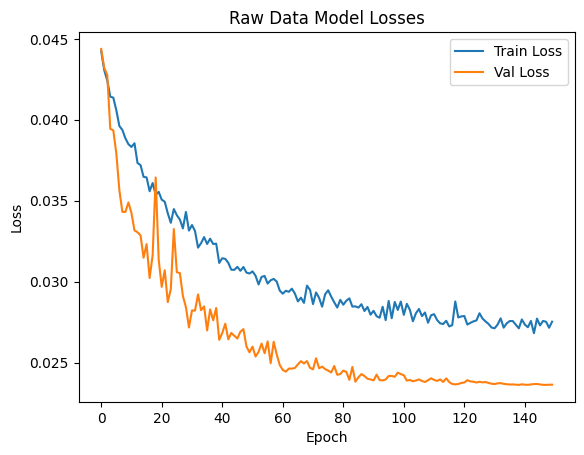

In [25]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

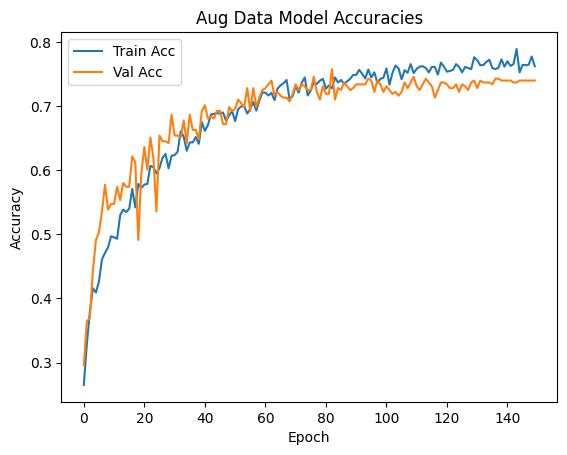

In [24]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Aug Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Train on Sub1 Data

In [15]:
device = torch.device('mps')

model = CNN()
model = model.to(device)
print(model)
summary(model, input_size=(1, 22, 1000), device='mps')

CNN(
  (conv_over_time): Sequential(
    (0): Conv2d(1, 24, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (conv_over_channels): Sequential(
    (0): Conv2d(24, 120, kernel_size=(22, 1), stride=(1, 1), groups=8)
    (1): BatchNorm2d(120, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv_by_channel_and_point): Sequential(
    (0): Conv2d(120, 120, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=8)
    (1): Conv2d(120, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 4, kernel_size=(1, 3

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 4]                    --
├─Sequential: 1-1                        [1, 24, 22, 1001]         --
│    └─Conv2d: 2-1                       [1, 24, 22, 1001]         1,560
│    └─BatchNorm2d: 2-2                  [1, 24, 22, 1001]         48
├─Sequential: 1-2                        [1, 120, 1, 250]          --
│    └─Conv2d: 2-3                       [1, 120, 1, 1001]         8,040
│    └─BatchNorm2d: 2-4                  [1, 120, 1, 1001]         240
│    └─ELU: 2-5                          [1, 120, 1, 1001]         --
│    └─AvgPool2d: 2-6                    [1, 120, 1, 250]          --
│    └─Dropout: 2-7                      [1, 120, 1, 250]          --
├─Sequential: 1-3                        [1, 4, 1, 1]              --
│    └─Conv2d: 2-8                       [1, 120, 1, 251]          28,920
│    └─Conv2d: 2-9                       [1, 32, 1, 251]           3,840
│

In [9]:
sub_model = model
sub_model.to(device)

optimizer = torch.optim.Adam(sub_model.parameters(), lr=0.001,  weight_decay=0.000001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

tr_loader = train_sub_loader

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=sub_model,
    optimizer=optimizer,
    loss_func=nn.CrossEntropyLoss(),
    train_data=tr_loader,
    val_data=val_loader,
    early_stopping_patience=30,
    scheduler=scheduler,
    cp_path="models/cnn",
    cp_filename="sub.pt",
    n_epochs=100,
    show_progress_bar=True,
)

/Users/yubo/miniforge3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using device: mps


Epoch 0: 100%|██████████| 7/7 [00:03<00:00,  2.21batch/s, loss=1.2316]


[Epoch 0] val_acc=0.292899 train_acc=0.306533 val_loss=0.044933 train_loss=0.048766
Validation loss decreased (inf --> 0.044933).  Saving model ...


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  4.60batch/s, loss=1.0382]


[Epoch 1] val_acc=0.286982 train_acc=0.507538 val_loss=0.045607 train_loss=0.041697
EarlyStopping counter: 1 out of 30


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  4.61batch/s, loss=1.1930]


[Epoch 2] val_acc=0.304734 train_acc=0.582915 val_loss=0.045905 train_loss=0.040063
EarlyStopping counter: 2 out of 30


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  4.60batch/s, loss=0.8736]


[Epoch 3] val_acc=0.310651 train_acc=0.668342 val_loss=0.046625 train_loss=0.036324
EarlyStopping counter: 3 out of 30


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  4.59batch/s, loss=0.8063]


[Epoch 4] val_acc=0.304734 train_acc=0.753769 val_loss=0.047013 train_loss=0.033599
EarlyStopping counter: 4 out of 30


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  4.58batch/s, loss=0.8525]


[Epoch 5] val_acc=0.313609 train_acc=0.793970 val_loss=0.046889 train_loss=0.030705
EarlyStopping counter: 5 out of 30


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  4.61batch/s, loss=0.7851]


[Epoch 6] val_acc=0.325444 train_acc=0.864322 val_loss=0.047203 train_loss=0.027801
EarlyStopping counter: 6 out of 30


Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  4.57batch/s, loss=0.9978]


[Epoch 7] val_acc=0.301775 train_acc=0.869347 val_loss=0.048934 train_loss=0.026993
EarlyStopping counter: 7 out of 30


Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  4.53batch/s, loss=0.5564]


[Epoch 8] val_acc=0.322485 train_acc=0.924623 val_loss=0.048645 train_loss=0.023731
EarlyStopping counter: 8 out of 30


Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, loss=0.5768]


[Epoch 9] val_acc=0.301775 train_acc=0.934673 val_loss=0.048448 train_loss=0.022722
EarlyStopping counter: 9 out of 30


Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  4.22batch/s, loss=0.6986]


[Epoch 10] val_acc=0.325444 train_acc=0.984925 val_loss=0.047112 train_loss=0.022114
EarlyStopping counter: 10 out of 30


Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  4.31batch/s, loss=0.5507]


[Epoch 11] val_acc=0.343195 train_acc=0.964824 val_loss=0.046439 train_loss=0.020697
EarlyStopping counter: 11 out of 30


Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  4.45batch/s, loss=0.5834]


[Epoch 12] val_acc=0.340237 train_acc=0.974874 val_loss=0.046256 train_loss=0.020592
EarlyStopping counter: 12 out of 30


Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  4.45batch/s, loss=0.4968]


[Epoch 13] val_acc=0.349112 train_acc=0.984925 val_loss=0.046102 train_loss=0.019536
EarlyStopping counter: 13 out of 30


Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  4.45batch/s, loss=0.5112]


[Epoch 14] val_acc=0.355030 train_acc=0.994975 val_loss=0.046456 train_loss=0.019013
EarlyStopping counter: 14 out of 30


Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  4.42batch/s, loss=0.5248]


[Epoch 15] val_acc=0.363905 train_acc=0.989950 val_loss=0.046690 train_loss=0.018892
EarlyStopping counter: 15 out of 30


Epoch 16: 100%|██████████| 7/7 [00:01<00:00,  4.40batch/s, loss=0.5538]


[Epoch 16] val_acc=0.360947 train_acc=0.994975 val_loss=0.047416 train_loss=0.018887
EarlyStopping counter: 16 out of 30


Epoch 17: 100%|██████████| 7/7 [00:01<00:00,  4.45batch/s, loss=0.4851]


[Epoch 17] val_acc=0.360947 train_acc=0.994975 val_loss=0.047351 train_loss=0.018290
EarlyStopping counter: 17 out of 30


Epoch 18: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, loss=0.5216]


[Epoch 18] val_acc=0.369822 train_acc=0.994975 val_loss=0.047481 train_loss=0.018121
EarlyStopping counter: 18 out of 30


Epoch 19: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, loss=0.5135]


[Epoch 19] val_acc=0.357988 train_acc=1.000000 val_loss=0.048947 train_loss=0.018044
EarlyStopping counter: 19 out of 30


Epoch 20: 100%|██████████| 7/7 [00:01<00:00,  4.46batch/s, loss=0.4991]


[Epoch 20] val_acc=0.378698 train_acc=0.989950 val_loss=0.049365 train_loss=0.017795
EarlyStopping counter: 20 out of 30


Epoch 21: 100%|██████████| 7/7 [00:01<00:00,  4.43batch/s, loss=0.5293]


[Epoch 21] val_acc=0.366864 train_acc=1.000000 val_loss=0.049982 train_loss=0.017805
EarlyStopping counter: 21 out of 30


Epoch 22: 100%|██████████| 7/7 [00:01<00:00,  4.44batch/s, loss=0.4992]


[Epoch 22] val_acc=0.352071 train_acc=1.000000 val_loss=0.050181 train_loss=0.017504
EarlyStopping counter: 22 out of 30


Epoch 23: 100%|██████████| 7/7 [00:01<00:00,  4.45batch/s, loss=0.5350]


[Epoch 23] val_acc=0.357988 train_acc=1.000000 val_loss=0.049840 train_loss=0.017564
EarlyStopping counter: 23 out of 30


Epoch 24: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, loss=0.4678]


[Epoch 24] val_acc=0.369822 train_acc=0.989950 val_loss=0.050179 train_loss=0.017524
EarlyStopping counter: 24 out of 30


Epoch 25: 100%|██████████| 7/7 [00:01<00:00,  4.49batch/s, loss=0.4682]


[Epoch 25] val_acc=0.352071 train_acc=1.000000 val_loss=0.050696 train_loss=0.017231
EarlyStopping counter: 25 out of 30


Epoch 26: 100%|██████████| 7/7 [00:01<00:00,  4.45batch/s, loss=0.4670]


[Epoch 26] val_acc=0.372781 train_acc=1.000000 val_loss=0.049912 train_loss=0.017274
EarlyStopping counter: 26 out of 30


Epoch 27: 100%|██████████| 7/7 [00:01<00:00,  4.46batch/s, loss=0.4837]


[Epoch 27] val_acc=0.360947 train_acc=1.000000 val_loss=0.050912 train_loss=0.017117
EarlyStopping counter: 27 out of 30


Epoch 28: 100%|██████████| 7/7 [00:01<00:00,  4.48batch/s, loss=0.4811]


[Epoch 28] val_acc=0.381657 train_acc=1.000000 val_loss=0.050220 train_loss=0.017051
EarlyStopping counter: 28 out of 30


Epoch 29: 100%|██████████| 7/7 [00:01<00:00,  4.43batch/s, loss=0.4648]


[Epoch 29] val_acc=0.375740 train_acc=1.000000 val_loss=0.049600 train_loss=0.016802
EarlyStopping counter: 29 out of 30


Epoch 30: 100%|██████████| 7/7 [00:01<00:00,  4.47batch/s, loss=0.4642]


[Epoch 30] val_acc=0.390533 train_acc=1.000000 val_loss=0.049785 train_loss=0.016659
EarlyStopping counter: 30 out of 30
Early stopping.


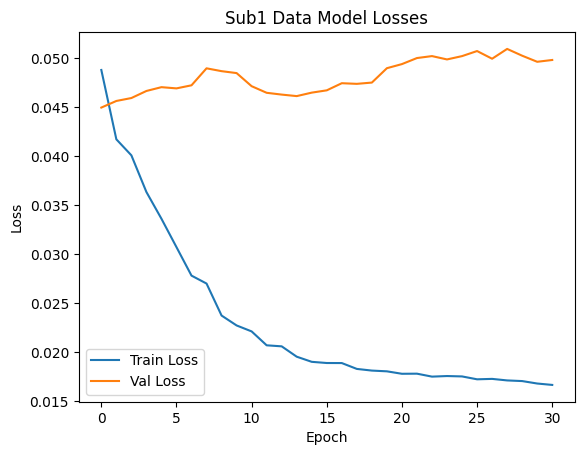

In [10]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Sub1 Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

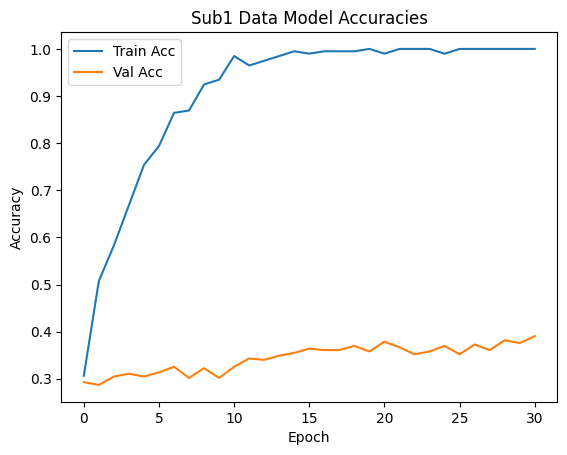

In [11]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Sub1 Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [13]:
# Load best model and test
sub1_model = torch.load("models/cnn/sub.pt")
sub1_model.to(device)
sub1_model.eval()

CNN(
  (conv_over_time): Sequential(
    (0): Conv2d(1, 24, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (conv_over_channels): Sequential(
    (0): Conv2d(24, 120, kernel_size=(22, 1), stride=(1, 1), groups=8)
    (1): BatchNorm2d(120, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv_by_channel_and_point): Sequential(
    (0): Conv2d(120, 120, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=8)
    (1): Conv2d(120, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 4, kernel_size=(1, 3

In [14]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_sub_loader:
        X, y = X.to(device), y.to(device)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_sub_loader.dataset)
print("Train on sub1 data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on sub1 data
Test Acc: 0.2600


## Time Series

In [39]:
class CNN_ts(nn.Module):
    def __init__(self, n_time=1000):
        super(CNN_ts, self).__init__()

        self.filter_nums1 = 24 # 8
        self.filter_nums2 = 120 # 40
        self.filter_nums3 = 32 # 12
        num_groups = 8
        b = True
        dropout_prob = 0.25

        self.conv_over_time = nn.Sequential(
            nn.Conv2d(1, self.filter_nums1, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=b),
            nn.BatchNorm2d(self.filter_nums1, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
        # (n, 8, 22, 1001)

        self.conv_over_channels = nn.Sequential(
            nn.Conv2d(self.filter_nums1, self.filter_nums2, kernel_size=(22, 1), stride=(1, 1), groups=num_groups, bias=b),
            nn.BatchNorm2d(self.filter_nums2, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0), # pool over time to shrink time
            nn.Dropout(p=dropout_prob)
        )
        # (n, 40, 1, 250)

        self.conv_by_channel_and_point = nn.Sequential(
            nn.Conv2d(self.filter_nums2, self.filter_nums2, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=num_groups, bias=b),
            # (n, 40, 1, 251)
            nn.Conv2d(self.filter_nums2, self.filter_nums3, kernel_size=(1, 1), stride=(1, 1), bias=False),
            # (n, 12, 1, 251)
            nn.BatchNorm2d(self.filter_nums3, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=dropout_prob),
            # (n, 12, 1, 31)
            # nn.Conv2d(self.filter_nums3, 4, kernel_size=(1, 31), stride=(1, 1)) # conv to 4 output classes
            # (n, 4, 1, 1)
        )

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(4) # the last convolution is replaced by linear
        )
        

    def forward(self, x):
        # x = x.to('mps')
        # X (batch, ch, t)
        x = x.unsqueeze(3)
        # (batch, ch, t, 1)
        x = x.permute(0, 3, 1, 2)
        # (batch, 1, ch, t)
        x = self.conv_over_time(x)
        x = self.conv_over_channels(x)
        x = self.conv_by_channel_and_point(x)
        x = self.linear(x)

        return x

In [44]:
device = torch.device('mps')

model = CNN_ts(n_time=250)
model = model.to(device)
print(model)
test_input = torch.randn((1, 22, 250)).to(device)
model(test_input).shape
summary(model, input_size=(1, 22, 250), device='mps')

CNN_ts(
  (conv_over_time): Sequential(
    (0): Conv2d(1, 24, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (conv_over_channels): Sequential(
    (0): Conv2d(24, 120, kernel_size=(22, 1), stride=(1, 1), groups=8)
    (1): BatchNorm2d(120, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv_by_channel_and_point): Sequential(
    (0): Conv2d(120, 120, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=8)
    (1): Conv2d(120, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.25, inplace=False)
  )
  (linear): Sequential(
    (0): 

Layer (type:depth-idx)                   Output Shape              Param #
CNN_ts                                   [1, 4]                    --
├─Sequential: 1-1                        [1, 24, 22, 251]          --
│    └─Conv2d: 2-1                       [1, 24, 22, 251]          1,560
│    └─BatchNorm2d: 2-2                  [1, 24, 22, 251]          48
├─Sequential: 1-2                        [1, 120, 1, 62]           --
│    └─Conv2d: 2-3                       [1, 120, 1, 251]          8,040
│    └─BatchNorm2d: 2-4                  [1, 120, 1, 251]          240
│    └─ELU: 2-5                          [1, 120, 1, 251]          --
│    └─AvgPool2d: 2-6                    [1, 120, 1, 62]           --
│    └─Dropout: 2-7                      [1, 120, 1, 62]           --
├─Sequential: 1-3                        [1, 32, 1, 7]             --
│    └─Conv2d: 2-8                       [1, 120, 1, 63]           28,920
│    └─Conv2d: 2-9                       [1, 32, 1, 63]            3,840
│

In [45]:
time_slots = [50, 100, 150, 200, 250, 500, 750, 1000]

In [46]:
valid_acc = {}
test_acc = {}

for ts in time_slots:
    train_data, valid_data, test_data = get_time_series_dataloader(ts)
    
    time_model = CNN_ts(n_time=ts)
    time_model.to(device)
    
    optimizer = torch.optim.Adam(time_model.parameters(), lr=0.001, weight_decay=1e-03)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    _ = train(
        model=time_model,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_func=nn.CrossEntropyLoss(),
        train_data=train_data,
        val_data=valid_data,
        early_stopping_patience=30,
        cp_path="models/cnn",
        cp_filename=f"time_{ts}.pt",
        n_epochs=100,
        show_progress_bar=False,
    )
    
    # Load best model and test
    time_model = torch.load(f"models/cnn/time_{ts}.pt")
    time_model.to(device)
    time_model.eval()
    
    # Evaluate validation accuracies
    valid_acc[ts] = 0
    with torch.no_grad():
        for X, y in valid_data:
            X, y = X.to(device), y.to(device)
            y_pred = time_model(X)
            valid_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    valid_acc[ts] /= len(valid_data.dataset)
    
    # Evaluate test accuracies
    test_acc[ts] = 0
    with torch.no_grad():
        for X, y in test_data:
            X, y = X.to(device), y.to(device)
            y_pred = time_model(X)
            test_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    test_acc[ts] /= len(test_data.dataset)

/Users/yubo/miniforge3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using device: mps
[Epoch 0] val_acc=0.331361 train_acc=0.328081 val_loss=0.024171 train_loss=0.021733
Validation loss decreased (inf --> 0.024171).  Saving model ...
[Epoch 1] val_acc=0.328402 train_acc=0.382667 val_loss=0.024043 train_loss=0.020867
Validation loss decreased (0.024171 --> 0.024043).  Saving model ...
[Epoch 2] val_acc=0.355030 train_acc=0.395611 val_loss=0.023851 train_loss=0.020508
Validation loss decreased (0.024043 --> 0.023851).  Saving model ...
[Epoch 3] val_acc=0.384615 train_acc=0.416432 val_loss=0.023639 train_loss=0.020364
Validation loss decreased (0.023851 --> 0.023639).  Saving model ...
[Epoch 4] val_acc=0.402367 train_acc=0.453573 val_loss=0.023616 train_loss=0.020035
Validation loss decreased (0.023639 --> 0.023616).  Saving model ...
[Epoch 5] val_acc=0.369822 train_acc=0.451322 val_loss=0.023503 train_loss=0.019923
Validation loss decreased (0.023616 --> 0.023503).  Saving model ...
[Epoch 6] val_acc=0.378698 train_acc=0.450760 val_loss=0.023470 train

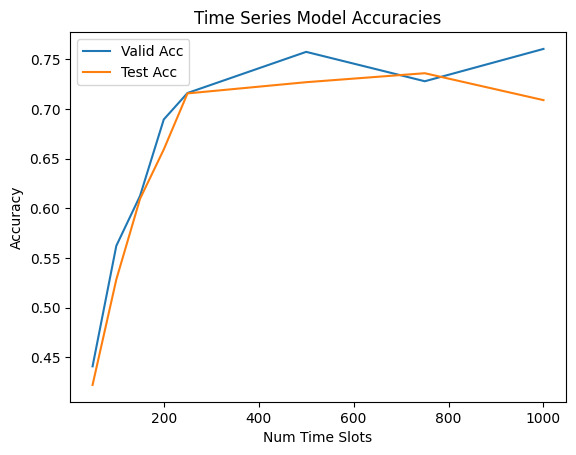

In [47]:
plt.plot(valid_acc.keys(), valid_acc.values(), label="Valid Acc")
plt.plot(test_acc.keys(), test_acc.values(), label="Test Acc")
plt.legend()
plt.title("Time Series Model Accuracies")
plt.xlabel("Num Time Slots")
plt.ylabel("Accuracy")
plt.show()